## Detecting My Favorite Animal: Cats


### Mission Statement
The objective of this project is to create a model that can detect my favorite animal, cats, in a given set of images. We will build a dataset from pre-existing datasets, describe the final dataset, define and implement our modeling strategy, and create a script to detect cats in new images.

### Dataset Description
We will use the annotated cat images dataset from Kaggle from https://www.kaggle.com/datasets/crawford/cat-dataset

#### About dataset 
**Context**: The CAT dataset includes over 9,000 cat images. For each image, there are annotations of the head of the cat with nine points: two for eyes, one for the mouth, and six for the ears.<br>

**Content**: The annotation data are stored in files with the same name as the corresponding image plus ".cat". Each annotation file contains:

- Number of points (default is 9)
- Left Eye
- Right Eye
- Mouth
- Left Ear-1, Left Ear-2, Left Ear-3
- Right Ear-1, Right Ear-2, Right Ear-3<br>

**Acknowledgements**: Weiwei Zhang, Jian Sun, and Xiaoou Tang, Cat Head Detection - How to Effectively Exploit Shape and Texture Features, Proc. of European Conf. Computer Vision, vol. 4, pp.802-816, 2008.


In [1]:
## TODO: EDA

### Dataset creation
Since the dataset is large (4GB), we will use a smaller portion of it and focus on boxing the cat faces.

#### Steps taken to use the dataset:
**Download Images and Annotations**: Download a manageable portion of the annotated cat images and their corresponding annotations from the Kaggle dataset.<br>

**Filter and Clean Data**: Ensure that the images and annotations are correctly formatted and only include images containing cat faces.<br>

**Convert Annotations**: Convert the nine-point annotations to bounding box coordinates for cat faces.
**Format for YOLO**: Convert the bounding box coordinates to the format required by YOLOv8.

### Tools and Libraries
- Kaggle Cat Dataset
- YOLOv8 for object detection
- OpenCV for image processing


### Final Dataset Description
The final dataset will consist of:

**Images**: JPG format images containing cats.
**Annotations**: Bounding box coordinates for each image to include the whole face.

### Modelization Strategy
We will use YOLOv8 (You Only Look Once) to build our model. YOLOv8 is known for its speed and accuracy in detecting objects in real-time.

#### Steps for Model Training:
**Preprocessing**: Resize images and normalize pixel values.<br>
**Data Augmentation**: Apply transformations such as rotation, scaling, and flipping to increase the diversity of the training set.<br>
**Model Training**: Train the YOLOv8 model on the labeled dataset, fine-tuning hyperparameters for optimal performance.<br>
**Evaluation**: Assess the model’s performance using metrics like Precision, Recall, and mAP (mean Average Precision).<br>


In [12]:

## import libraries 
import numpy as np
import pandas as pd
import os
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


In [3]:
dataset_path = 'data/CAT_00'

## preprocess images
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (416, 416)) ## yolov8 takes 416?
    image = image/255.0 ## normalize pixel values
    return image

def points_to_bbox(points): 
    x_coords = points[::2]
    y_coords = points[1::2]
    xmin, xmax = min(x_coords), max(x_coords) ## take extreme values of x and y
    ymin, ymax = min(y_coords), max(y_coords)
    return [xmin, xmax, ymin, ymax] ## return one big box of the whole face



In [4]:
## Load images and thier annotations 
images = [f'{dataset_path}/{img}' 
          for img in os.listdir(dataset_path) 
          if img.endswith('.jpg')] 
annotations = [f'{dataset_path}/{img}' 
          for img in os.listdir(dataset_path) 
          if img.endswith('.cat')] 

In [5]:
preprocessed_images = [preprocess(img) for img in tqdm(images, desc=f"Preprocessing Images")]

Preprocessing Images:   0%|          | 0/1706 [00:00<?, ?it/s]

In [6]:
## convert annotations 
yolo_annotations = []
for annot in tqdm(annotations, desc=f"Changing annotations to bbox"): 
    with open(annot, 'r') as file:
        points = list(map(int, file.read().strip().split()[1:]))
        bbox = points_to_bbox(points)
        yolo_annotations.append(bbox)

Changing annotations to bbox:   0%|          | 0/1706 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


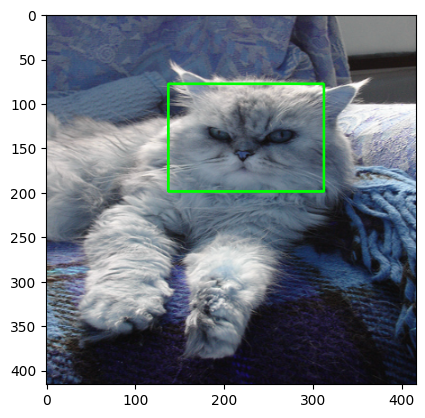

In [7]:
x1, x2, y1, y2 = yolo_annotations[0]
img = preprocessed_images[0]
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [15]:
## TODO: finally 


def convert_to_yolo_format(bbox, img_width, img_height):
    x_center = (bbox[0] + bbox[2])/ 2.0 / img_width
    y_center = (bbox[1] + bbox[3])/ 2.0 / img_height
    width = (bbox[2] - bbox[0]) / img_width
    height = (bbox[3] - bbox[1]) / img_height
    return [x_center, y_center, width, height]

yolo_formatted_annotations = [convert_to_yolo_format(bbox, 416, 416) for bbox in tqdm(yolo_annotations, desc="Converting annotations to yolo format")]


Converting annotations to yolo format:   0%|          | 0/1706 [00:00<?, ?it/s]

In [16]:
# 
# Train YOLOmodel 
#

model = YOLO("yolov8s.pt") 
train_data = [(img, ann) for img, ann in zip(preprocessed_images, yolo_formatted_annotations)]


In [19]:
## Evaluate the model
results = model.val(data=train_data[:100])  # Evaluate on the first 100 samples

precision = results['metrics/precision']
recall = results['metrics/recall']
map = results['metrics/mAP_0.5']

# Display evaluation metrics
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, mAP: {map:.2f}")

# Plot some results
for img_path in images[:5]:  # Display results for the first 5 images
    img = cv2.imread(img_path)
    detections = model.predict(img)
    for detection in detections:
        x1, y1, x2, y2 = detection[:4]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


Ultralytics YOLOv8.2.48  Python-3.12.3 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)


FileNotFoundError: Dataset '[(array([[[    0.32941,     0.32941,     0.45098],
        [    0.30196,     0.34118,     0.44706],
        [    0.33333,     0.30588,     0.46667],
        ...,
        [    0.52941,     0.53725,     0.54118],
        [    0.52941,     0.53725,     0.53725],
        [    0.52941,     0.53725,     0.53725]],

       [[    0.25098,     0.29804,      0.4549],
        [    0.26275,     0.34902,     0.42745],
        [    0.27843,     0.32941,     0.43137],
        ...,
        [    0.53333,     0.53725,     0.53725],
        [    0.52941,     0.53725,     0.53725],
        [    0.52941,     0.53725,     0.53725]],

       [[    0.27843,     0.33333,     0.46275],
        [    0.28235,     0.31765,     0.42745],
        [    0.27451,     0.31373,     0.43137],
        ...,
        [    0.52941,     0.53725,     0.53333],
        [    0.53333,     0.53725,     0.53725],
        [    0.53333,     0.53333,     0.53333]],

       ...,

       [[    0.29804,     0.38039,      0.4902],
        [    0.29804,     0.39216,     0.49412],
        [     0.2549,     0.37255,     0.48235],
        ...,
        [   0.066667,    0.062745,     0.14902],
        [   0.047059,    0.058824,     0.12157],
        [   0.043137,    0.066667,     0.12549]],

       [[    0.21961,     0.28235,         0.4],
        [    0.25098,     0.27843,     0.41176],
        [    0.18824,     0.29412,     0.39608],
        ...,
        [   0.078431,    0.082353,     0.19216],
        [   0.070588,    0.086275,     0.18431],
        [   0.058824,    0.098039,     0.19216]],

       [[    0.17255,     0.24314,     0.36471],
        [    0.17255,     0.17647,     0.29412],
        [    0.17255,     0.18431,     0.31373],
        ...,
        [   0.070588,    0.090196,     0.21569],
        [   0.082353,    0.098039,     0.21961],
        [    0.07451,     0.10588,     0.23137]]]), [0.25841346153846156, 0.6141826923076923, -0.14182692307692307, -0.27163461538461536]), (array([[[    0.57255,     0.59608,         0.6],
        [    0.55686,     0.59216,     0.58431],
        [     0.5451,     0.59216,     0.57647],
        ...,
        [    0.50196,      0.5451,     0.56078],
        [    0.49804,      0.5451,     0.56078],
        [    0.47843,     0.53725,     0.54902]],

       [[    0.56078,     0.58039,     0.58431],
        [    0.55686,     0.58824,     0.58431],
        [    0.54902,     0.58824,     0.57647],
        ...,
        [    0.51373,     0.55294,     0.56471],
        [     0.5098,     0.55686,     0.56471],
        [    0.48627,     0.53725,      0.5451]],

       [[    0.53333,     0.55686,     0.55686],
        [    0.57255,     0.59608,     0.59216],
        [    0.56078,     0.58824,     0.58431],
        ...,
        [    0.51765,     0.56078,     0.56078],
        [    0.52549,     0.56863,     0.56863],
        [    0.50196,     0.54902,     0.55686]],

       ...,

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.41569,     0.44706,     0.59216],
        [    0.39216,     0.42353,     0.57647],
        [    0.38039,     0.40392,     0.56863]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [        0.4,     0.42353,     0.60392],
        [    0.41176,     0.43529,     0.61176],
        [    0.39216,     0.41569,     0.58431]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.36078,         0.4,     0.56863],
        [    0.36863,     0.40392,     0.56078],
        [    0.39216,     0.43137,     0.56863]]]), [0.013221153846153846, 0.4879807692307692, -0.20432692307692307, -0.27403846153846156]), (array([[[    0.32941,      0.3098,     0.38431],
        [    0.25098,     0.29412,      0.3451],
        [     0.2549,     0.32157,     0.37255],
        ...,
        [    0.63137,     0.64706,     0.66667],
        [    0.60784,     0.61176,     0.63922],
        [    0.58824,     0.58431,     0.62353]],

       [[    0.24314,     0.31373,      0.3451],
        [    0.30196,     0.34902,     0.38039],
        [    0.31373,     0.32549,     0.38824],
        ...,
        [    0.70196,     0.71765,     0.71765],
        [    0.67843,     0.67843,      0.6902],
        [    0.65098,     0.64706,     0.66667]],

       [[    0.24706,     0.27059,     0.36863],
        [    0.29412,     0.30588,     0.38039],
        [    0.25882,     0.28235,     0.34118],
        ...,
        [    0.64314,     0.67451,     0.68235],
        [    0.69804,     0.71373,     0.72549],
        [    0.65098,     0.65882,     0.67451]],

       ...,

       [[    0.72941,     0.71373,      0.7098],
        [    0.75294,     0.73725,     0.73333],
        [    0.76471,      0.7451,     0.74902],
        ...,
        [     0.7098,     0.72549,     0.72157],
        [    0.75686,     0.77255,     0.77647],
        [    0.72157,     0.73333,     0.74902]],

       [[    0.76471,     0.74902,     0.74902],
        [    0.78039,     0.76471,     0.76471],
        [    0.78039,     0.77255,     0.77255],
        ...,
        [    0.63137,     0.62353,     0.62745],
        [    0.68235,     0.68235,     0.69412],
        [    0.65098,     0.65098,     0.67451]],

       [[    0.77255,     0.75294,     0.75686],
        [    0.75686,      0.7451,      0.7451],
        [    0.77255,     0.77647,     0.77647],
        ...,
        [    0.69804,     0.68235,      0.6902],
        [    0.66275,      0.6549,     0.66667],
        [    0.65882,     0.65098,     0.67059]]]), [0.5805288461538461, 0.7199519230769231, -0.2860576923076923, -0.2956730769230769]), (array([[[    0.65098,     0.59216,     0.70196],
        [     0.6902,     0.63922,     0.72941],
        [    0.63922,     0.59608,     0.67451],
        ...,
        [    0.76078,     0.50196,     0.83922],
        [    0.72157,     0.45098,     0.83137],
        [    0.70196,     0.43137,     0.84314]],

       [[    0.80784,     0.75686,      0.8549],
        [    0.67451,     0.61176,     0.71373],
        [    0.67059,     0.58039,     0.68235],
        ...,
        [    0.76863,     0.51373,     0.84706],
        [    0.72941,     0.46667,     0.84314],
        [     0.7098,     0.43922,     0.85098]],

       [[    0.89412,     0.84314,      0.8902],
        [    0.74118,     0.66667,     0.74118],
        [    0.72941,     0.61961,     0.71373],
        ...,
        [    0.77255,     0.52157,     0.85098],
        [    0.73333,     0.47451,     0.85098],
        [     0.7098,     0.43922,     0.84314]],

       ...,

       [[    0.50196,         0.4,     0.51373],
        [    0.53333,     0.42745,     0.56471],
        [    0.47843,     0.34118,     0.51765],
        ...,
        [    0.68235,     0.58039,      0.7098],
        [    0.67843,     0.57255,     0.70588],
        [    0.66667,     0.57647,     0.70196]],

       [[    0.62353,     0.55686,     0.67059],
        [    0.60784,     0.52549,     0.67451],
        [    0.42745,     0.31373,     0.50196],
        ...,
        [    0.66275,     0.57255,     0.70588],
        [    0.66275,     0.57255,     0.70588],
        [    0.64706,     0.56078,     0.69412]],

       [[    0.56863,     0.46275,     0.59216],
        [    0.43529,     0.32549,      0.4902],
        [     0.4549,     0.32941,     0.53333],
        ...,
        [     0.6549,     0.58824,     0.69412],
        [    0.65098,     0.58431,     0.69412],
        [    0.62745,     0.56471,     0.67843]]]), [0.1346153846153846, 0.7211538461538461, -0.2692307692307692, -0.2548076923076923]), (array([[[    0.40392,     0.30588,     0.22745],
        [    0.40392,     0.30588,     0.22745],
        [        0.4,     0.30196,     0.22353],
        ...,
        [    0.10196,    0.078431,     0.05098],
        [    0.10196,    0.078431,     0.05098],
        [    0.10196,    0.078431,     0.05098]],

       [[    0.40784,      0.3098,     0.23137],
        [    0.40784,      0.3098,     0.23137],
        [    0.40392,     0.30588,     0.22745],
        ...,
        [    0.10196,    0.078431,     0.05098],
        [    0.10196,    0.078431,     0.05098],
        [    0.10196,    0.078431,     0.05098]],

       [[    0.41569,     0.31765,     0.23529],
        [    0.41176,     0.31765,     0.23529],
        [    0.40784,     0.31373,     0.23137],
        ...,
        [    0.10196,    0.078431,     0.05098],
        [    0.10196,    0.078431,     0.05098],
        [    0.10196,    0.078431,     0.05098]],

       ...,

       [[    0.14902,     0.13333,    0.090196],
        [    0.13333,     0.11765,     0.07451],
        [    0.12549,      0.1098,    0.066667],
        ...,
        [   0.039216,    0.039216,    0.023529],
        [   0.039216,    0.039216,    0.023529],
        [   0.043137,    0.043137,    0.027451]],

       [[    0.13725,     0.11765,    0.078431],
        [    0.12549,      0.1098,    0.066667],
        [    0.11765,     0.10196,    0.058824],
        ...,
        [   0.031373,    0.035294,    0.023529],
        [   0.035294,    0.039216,    0.023529],
        [   0.039216,    0.043137,    0.027451]],

       [[    0.12549,      0.1098,    0.066667],
        [    0.11765,     0.10196,    0.058824],
        [    0.11373,    0.098039,    0.054902],
        ...,
        [   0.035294,    0.039216,    0.023529],
        [   0.035294,    0.043137,    0.027451],
        [   0.039216,    0.043137,    0.027451]]]), [0.12259615384615384, 0.5408653846153846, -0.20192307692307693, -0.2692307692307692]), (array([[[    0.23137,     0.27843,     0.23922],
        [    0.24706,     0.27451,     0.25098],
        [     0.2549,     0.27059,     0.25098],
        ...,
        [    0.21176,      0.2549,     0.24314],
        [    0.21569,      0.2549,     0.25098],
        [    0.21176,     0.24706,     0.25882]],

       [[    0.21569,      0.2549,     0.23922],
        [    0.25882,     0.28627,     0.26667],
        [    0.26275,     0.29412,     0.25098],
        ...,
        [    0.23922,     0.27451,     0.26667],
        [    0.23529,     0.26667,     0.26275],
        [    0.22745,     0.25882,     0.26275]],

       [[    0.26275,     0.27843,     0.28235],
        [    0.24314,     0.27059,     0.25098],
        [     0.2549,      0.2902,     0.24314],
        ...,
        [    0.23137,     0.25882,      0.2549],
        [    0.22353,     0.25098,     0.24706],
        [    0.20392,     0.23529,     0.22745]],

       ...,

       [[    0.07451,     0.12157,     0.21961],
        [   0.086275,      0.1098,     0.20784],
        [   0.054902,    0.086275,     0.18824],
        ...,
        [   0.090196,     0.12941,     0.20392],
        [   0.078431,     0.11373,     0.19608],
        [   0.058824,     0.10196,     0.17647]],

       [[    0.07451,     0.12157,     0.22745],
        [   0.090196,     0.12157,     0.21961],
        [   0.066667,     0.11765,     0.23137],
        ...,
        [   0.054902,    0.094118,     0.16078],
        [   0.043137,    0.082353,     0.15294],
        [   0.054902,    0.094118,     0.16078]],

       [[   0.054902,    0.090196,     0.18431],
        [   0.062745,     0.10588,     0.21176],
        [   0.058824,     0.12549,     0.24706],
        ...,
        [    0.07451,     0.11373,     0.18039],
        [   0.066667,     0.10588,     0.17647],
        [   0.066667,     0.10588,     0.18039]]]), [0.5588942307692307, 0.9266826923076923, -0.41586538461538464, -0.43028846153846156]), (array([[[    0.48235,      0.5098,     0.56078],
        [    0.46667,      0.4902,     0.57647],
        [     0.4549,     0.48235,     0.58824],
        ...,
        [    0.67451,     0.72157,     0.84314],
        [    0.66275,      0.7098,     0.83922],
        [    0.66275,      0.7451,     0.83529]],

       [[    0.44314,     0.43922,     0.51765],
        [     0.4902,     0.48627,     0.59608],
        [    0.47059,     0.48627,     0.58824],
        ...,
        [    0.68627,     0.70588,     0.82353],
        [    0.69412,     0.71765,     0.83529],
        [    0.70588,     0.76078,     0.84706]],

       [[    0.44314,     0.43137,     0.51765],
        [    0.47059,     0.45098,      0.5451],
        [    0.48627,     0.47843,     0.56471],
        ...,
        [    0.67451,      0.7098,     0.81961],
        [    0.68627,     0.73333,     0.83922],
        [    0.70588,     0.77255,      0.8549]],

       ...,

       [[   0.043137,     0.16863,     0.27843],
        [    0.05098,     0.17255,     0.28235],
        [   0.066667,     0.18824,     0.29412],
        ...,
        [    0.43922,      0.4549,     0.59608],
        [        0.4,      0.4549,     0.58431],
        [    0.38431,     0.47059,     0.58039]],

       [[   0.043137,     0.17647,     0.23529],
        [   0.035294,     0.16471,     0.23529],
        [   0.070588,     0.19216,     0.27059],
        ...,
        [    0.47059,     0.51765,     0.60784],
        [    0.44314,     0.50196,     0.60784],
        [    0.39608,     0.45882,     0.56078]],

       [[    0.05098,     0.18039,     0.28235],
        [   0.047059,     0.18824,     0.28235],
        [   0.082353,     0.20392,     0.29804],
        ...,
        [    0.49804,     0.55294,     0.61961],
        [    0.48235,     0.52941,     0.64314],
        [    0.43137,     0.47451,     0.58039]]]), [0.22596153846153846, 1.2764423076923077, -0.09134615384615384, -0.1778846153846154]), (array([[[   0.043137,    0.047059,    0.039216],
        [   0.039216,    0.043137,    0.035294],
        [   0.039216,    0.039216,    0.035294],
        ...,
        [    0.37647,         0.4,     0.38431],
        [    0.37255,     0.39216,     0.38431],
        [    0.37255,     0.39216,     0.38431]],

       [[   0.039216,    0.043137,    0.035294],
        [   0.039216,    0.043137,    0.035294],
        [   0.039216,    0.039216,    0.035294],
        ...,
        [    0.38431,     0.40784,     0.38824],
        [    0.38039,         0.4,     0.38824],
        [    0.37647,     0.39608,     0.38824]],

       [[   0.035294,    0.039216,    0.031373],
        [   0.035294,    0.039216,    0.031373],
        [   0.039216,    0.039216,    0.039216],
        ...,
        [    0.38824,     0.41176,     0.39216],
        [    0.38431,     0.40392,     0.39216],
        [    0.38039,         0.4,     0.39216]],

       ...,

       [[  0.0078431,   0.0078431,   0.0078431],
        [  0.0078431,   0.0078431,   0.0078431],
        [  0.0078431,   0.0078431,   0.0078431],
        ...,
        [    0.25098,     0.25882,     0.27843],
        [    0.23529,     0.25098,     0.26667],
        [    0.21569,     0.23529,     0.25098]],

       [[  0.0078431,   0.0078431,   0.0078431],
        [  0.0078431,   0.0078431,   0.0078431],
        [  0.0078431,   0.0078431,   0.0078431],
        ...,
        [    0.23529,      0.2549,     0.26667],
        [    0.22745,     0.25098,     0.26275],
        [    0.20784,     0.23529,     0.24706]],

       [[  0.0078431,   0.0078431,   0.0078431],
        [  0.0078431,   0.0078431,   0.0078431],
        [  0.0078431,   0.0078431,   0.0078431],
        ...,
        [    0.21569,     0.23137,     0.24314],
        [    0.22353,     0.24314,     0.24706],
        [    0.20784,     0.22745,     0.23137]]]), [0.21754807692307693, 0.7956730769230769, -0.37740384615384615, -0.6298076923076923]), (array([[[    0.41176,     0.42745,     0.43137],
        [    0.41961,     0.43529,     0.43922],
        [    0.41961,     0.43529,     0.43922],
        ...,
        [     0.3451,     0.37255,     0.38431],
        [    0.34118,     0.36863,     0.38039],
        [    0.34118,     0.36863,     0.38039]],

       [[    0.40784,     0.42353,     0.42745],
        [    0.41961,     0.43529,     0.43922],
        [    0.42745,     0.44314,     0.44706],
        ...,
        [    0.33333,     0.36471,     0.37255],
        [    0.32941,     0.35686,     0.36863],
        [    0.32941,     0.35686,     0.36863]],

       [[    0.41176,     0.42745,     0.43137],
        [    0.41961,     0.43529,     0.43922],
        [    0.42353,     0.43922,     0.44314],
        ...,
        [    0.32941,     0.35686,     0.36863],
        [    0.32941,     0.35686,     0.36863],
        [    0.32549,     0.35294,     0.36471]],

       ...,

       [[    0.62353,     0.64706,     0.67059],
        [    0.63137,     0.65882,     0.67843],
        [    0.61961,     0.64314,     0.66275],
        ...,
        [    0.21961,     0.22745,     0.23922],
        [    0.32941,     0.34118,     0.36078],
        [    0.27843,     0.28627,     0.31765]],

       [[        0.6,     0.61961,     0.65098],
        [    0.61569,     0.63922,     0.66667],
        [    0.59216,     0.61569,     0.64314],
        ...,
        [    0.29804,      0.3098,     0.31765],
        [    0.38431,     0.40392,     0.41961],
        [    0.35686,     0.37255,         0.4]],

       [[    0.59608,     0.61569,     0.65098],
        [    0.59608,     0.61569,     0.65098],
        [     0.5451,     0.56471,     0.60392],
        ...,
        [     0.3098,     0.32941,     0.32941],
        [    0.31765,     0.34118,     0.34902],
        [    0.36863,     0.39216,     0.41176]]]), [0.27884615384615385, 0.6923076923076923, -0.5, -0.5240384615384616]), (array([[[    0.66667,     0.69804,     0.69412],
        [    0.67059,     0.69804,     0.69412],
        [    0.67843,     0.70196,     0.69804],
        ...,
        [    0.76078,     0.70196,     0.66275],
        [    0.75686,     0.69804,     0.66275],
        [    0.75686,     0.69412,     0.66667]],

       [[    0.66667,     0.69804,     0.69412],
        [    0.67059,     0.69804,     0.69412],
        [    0.67843,     0.70196,     0.69804],
        ...,
        [    0.76078,     0.70588,      0.6549],
        [    0.75686,     0.70588,      0.6549],
        [    0.75686,     0.69804,     0.65882]],

       [[    0.66667,     0.69804,     0.69412],
        [    0.67059,     0.69804,     0.69412],
        [    0.67843,     0.70196,     0.69804],
        ...,
        [    0.76078,      0.7098,      0.6549],
        [    0.76078,      0.7098,      0.6549],
        [    0.75686,     0.70196,      0.6549]],

       ...,

       [[    0.22353,     0.27451,     0.28235],
        [    0.18039,     0.21961,     0.22745],
        [    0.12157,      0.1451,     0.14902],
        ...,
        [    0.05098,    0.054902,    0.070588],
        [   0.047059,     0.05098,    0.066667],
        [   0.047059,    0.054902,    0.058824]],

       [[    0.15294,     0.19608,     0.20392],
        [    0.10588,     0.13333,     0.14118],
        [   0.062745,     0.07451,    0.078431],
        ...,
        [   0.047059,    0.054902,    0.070588],
        [   0.047059,    0.054902,    0.070588],
        [    0.05098,    0.058824,    0.062745]],

       [[   0.070588,     0.10196,     0.11373],
        [    0.05098,    0.070588,     0.07451],
        [   0.047059,    0.054902,    0.058824],
        ...,
        [   0.039216,     0.05098,    0.066667],
        [   0.043137,    0.054902,    0.070588],
        [   0.054902,    0.062745,    0.066667]]]), [0.3329326923076923, 0.5985576923076923, -0.28125, -0.375]), (array([[[    0.32549,     0.23529,     0.46667],
        [    0.93333,     0.90196,     0.94118],
        [    0.77255,     0.77647,     0.75686],
        ...,
        [    0.51765,     0.50196,     0.48235],
        [    0.51765,     0.50196,     0.48235],
        [    0.52549,      0.5098,     0.48627]],

       [[    0.27059,     0.24706,     0.36078],
        [     0.9098,      0.8902,      0.9451],
        [    0.74902,     0.78431,     0.70588],
        ...,
        [    0.47059,     0.46667,     0.42745],
        [    0.46667,     0.45882,     0.42353],
        [    0.47451,     0.47059,     0.43137]],

       [[    0.18431,     0.18039,      0.3098],
        [    0.72941,     0.72157,     0.80784],
        [    0.67843,     0.74118,     0.64706],
        ...,
        [    0.48235,     0.48627,     0.44706],
        [    0.47451,     0.47843,     0.43922],
        [     0.4902,     0.49412,      0.4549]],

       ...,

       [[    0.38824,     0.39608,     0.39608],
        [    0.34902,     0.35294,     0.35686],
        [    0.32941,     0.34118,     0.33725],
        ...,
        [    0.40392,     0.43529,     0.42745],
        [    0.38431,     0.41961,     0.40784],
        [    0.41961,      0.4549,     0.44314]],

       [[        0.4,     0.39608,     0.40392],
        [    0.27451,     0.27451,     0.27843],
        [    0.30196,     0.31765,     0.31373],
        ...,
        [    0.42353,     0.45098,     0.43922],
        [    0.40784,     0.43529,     0.42353],
        [    0.43922,     0.46667,      0.4549]],

       [[    0.43137,     0.41569,     0.42353],
        [    0.30196,     0.29412,     0.30196],
        [    0.29804,     0.31765,     0.31373],
        ...,
        [    0.46275,     0.48235,     0.47451],
        [    0.45098,     0.47059,     0.46275],
        [    0.47843,     0.49804,      0.4902]]]), [0.39903846153846156, 0.7668269230769231, -0.7740384615384616, -0.7403846153846154]), (array([[[    0.24706,     0.20392,     0.20784],
        [    0.23922,     0.20392,     0.20784],
        [    0.23137,     0.21569,     0.20392],
        ...,
        [    0.71373,     0.61176,     0.33725],
        [    0.73333,     0.61176,     0.33725],
        [    0.71765,     0.61961,     0.33725]],

       [[    0.21176,         0.2,     0.19216],
        [    0.22745,     0.20784,     0.20392],
        [    0.22745,     0.20784,     0.20392],
        ...,
        [    0.72157,     0.61569,     0.33725],
        [    0.72157,     0.61961,     0.32157],
        [    0.72157,     0.61961,     0.31765]],

       [[    0.22745,         0.2,     0.18431],
        [    0.21961,     0.19608,     0.18824],
        [    0.23529,     0.21176,     0.20784],
        ...,
        [    0.72549,     0.61176,     0.32941],
        [    0.72157,     0.61569,     0.32549],
        [    0.72549,     0.61961,     0.32941]],

       ...,

       [[    0.19216,     0.22353,     0.26275],
        [    0.18039,     0.21961,     0.24314],
        [    0.18431,     0.22353,     0.25882],
        ...,
        [    0.66275,     0.67451,     0.70588],
        [    0.67059,     0.66667,     0.70588],
        [    0.67059,     0.66275,      0.7098]],

       [[    0.18824,     0.21961,     0.27843],
        [        0.2,     0.23529,     0.28235],
        [    0.21961,     0.25098,     0.30196],
        ...,
        [    0.66667,     0.66667,     0.70196],
        [    0.67843,     0.67059,     0.70588],
        [    0.67451,     0.66667,      0.7098]],

       [[    0.15686,     0.20784,     0.24314],
        [    0.18431,     0.21961,     0.26275],
        [        0.2,     0.23529,     0.27059],
        ...,
        [    0.67843,     0.66275,     0.71765],
        [    0.68627,     0.67059,     0.71373],
        [    0.67451,     0.67059,     0.71765]]]), [0.15384615384615385, 1.9194711538461537, -0.27884615384615385, -0.6418269230769231]), (array([[[    0.68627,     0.77647,     0.88235],
        [     0.6902,     0.77255,     0.88235],
        [    0.68235,     0.77255,     0.87843],
        ...,
        [    0.18824,     0.18824,     0.17647],
        [        0.2,     0.18431,     0.18431],
        [        0.2,     0.19608,     0.16471]],

       [[    0.67451,     0.76471,     0.86667],
        [    0.67451,     0.76471,     0.86667],
        [    0.67059,     0.75686,     0.86275],
        ...,
        [    0.18824,     0.19216,     0.18824],
        [    0.17647,     0.19608,     0.18824],
        [    0.18824,     0.18824,     0.17255]],

       [[    0.67059,     0.76471,      0.8549],
        [    0.65882,     0.76078,      0.8549],
        [    0.66667,     0.75294,      0.8549],
        ...,
        [    0.19608,     0.19608,     0.19216],
        [        0.2,     0.19608,     0.18039],
        [    0.18431,     0.19216,     0.18824]],

       ...,

       [[    0.35686,     0.47843,     0.58039],
        [    0.35686,     0.47843,     0.57647],
        [    0.34902,     0.47843,     0.58039],
        ...,
        [    0.52941,     0.52941,     0.53333],
        [    0.52157,     0.53725,     0.54118],
        [    0.51765,     0.53333,     0.53725]],

       [[    0.35686,     0.47451,     0.57647],
        [    0.35686,     0.48235,     0.57255],
        [    0.34902,     0.47843,     0.58824],
        ...,
        [    0.53333,     0.54118,      0.5451],
        [    0.53725,      0.5451,      0.5451],
        [    0.52941,      0.5451,     0.54902]],

       [[    0.35294,     0.47059,     0.57647],
        [    0.35686,     0.47843,     0.58039],
        [    0.34902,     0.47059,     0.57647],
        ...,
        [    0.53333,     0.54118,     0.54118],
        [    0.53725,     0.54118,     0.54118],
        [    0.53333,      0.5451,     0.54902]]]), [0.07692307692307693, 1.5805288461538463, -0.28846153846153844, -0.7379807692307693]), (array([[[    0.10196,      0.3098,     0.59608],
        [    0.13333,     0.38431,     0.67059],
        [    0.14118,     0.43529,     0.72941],
        ...,
        [   0.062745,    0.078431,    0.090196],
        [    0.05098,    0.070588,    0.062745],
        [   0.066667,    0.086275,     0.07451]],

       [[   0.090196,     0.29804,     0.58431],
        [    0.13333,     0.37647,     0.66667],
        [    0.14118,     0.43137,     0.72549],
        ...,
        [   0.058824,    0.086275,      0.1098],
        [   0.047059,     0.07451,    0.070588],
        [    0.05098,    0.078431,    0.066667]],

       [[   0.090196,      0.2902,     0.56863],
        [    0.13725,     0.37647,     0.65882],
        [    0.13725,     0.42353,     0.71373],
        ...,
        [   0.047059,    0.082353,     0.11765],
        [    0.05098,    0.082353,    0.078431],
        [   0.047059,     0.07451,    0.062745]],

       ...,

       [[     0.1098,     0.32549,     0.58824],
        [    0.10588,     0.32157,     0.58824],
        [     0.1098,     0.32549,     0.58824],
        ...,
        [    0.10196,      0.2902,     0.52549],
        [   0.098039,     0.24706,     0.48235],
        [   0.086275,     0.23137,     0.46667]],

       [[     0.1098,     0.32549,     0.58824],
        [    0.10196,     0.31765,     0.58039],
        [    0.11765,     0.32941,     0.59216],
        ...,
        [    0.11373,     0.30196,      0.5451],
        [    0.10588,     0.26275,     0.50196],
        [   0.078431,     0.23137,     0.47451]],

       [[     0.1098,     0.32549,     0.58824],
        [     0.1098,     0.32549,     0.58824],
        [    0.11765,     0.32941,     0.59216],
        ...,
        [    0.11373,      0.3098,     0.56078],
        [    0.11765,     0.28627,     0.53333],
        [   0.090196,     0.26275,     0.50196]]]), [0.09975961538461539, 0.7596153846153846, -0.18509615384615385, -0.15384615384615385]), (array([[[   0.023529,    0.015686,    0.015686],
        [   0.035294,    0.027451,    0.027451],
        [   0.039216,    0.019608,    0.023529],
        ...,
        [   0.039216,    0.043137,    0.035294],
        [   0.039216,    0.035294,    0.035294],
        [   0.039216,    0.031373,    0.031373]],

       [[   0.035294,    0.027451,    0.023529],
        [   0.043137,    0.031373,    0.035294],
        [    0.05098,    0.031373,    0.035294],
        ...,
        [   0.043137,    0.047059,    0.039216],
        [   0.035294,    0.035294,    0.031373],
        [   0.039216,    0.031373,    0.031373]],

       [[   0.039216,    0.031373,    0.027451],
        [   0.047059,    0.035294,    0.035294],
        [   0.047059,    0.027451,    0.031373],
        ...,
        [   0.047059,    0.054902,    0.047059],
        [   0.039216,    0.043137,    0.039216],
        [   0.031373,    0.027451,    0.027451]],

       ...,

       [[    0.11373,     0.19608,     0.21569],
        [   0.098039,     0.18039,     0.18431],
        [    0.12549,     0.21961,     0.21176],
        ...,
        [    0.31373,     0.37255,     0.40784],
        [     0.2902,     0.40784,     0.44314],
        [    0.16863,      0.3451,     0.38039]],

       [[   0.086275,     0.17647,     0.20784],
        [   0.082353,     0.18431,     0.19216],
        [     0.1098,     0.22353,     0.21176],
        ...,
        [    0.24314,     0.34118,     0.38039],
        [    0.30196,     0.44314,     0.47843],
        [        0.2,     0.33725,     0.37255]],

       [[    0.12941,     0.21961,     0.27451],
        [   0.090196,     0.20392,     0.22353],
        [    0.10196,     0.23529,     0.21961],
        ...,
        [    0.18039,     0.34902,     0.38431],
        [    0.27843,     0.43529,     0.46667],
        [    0.24706,     0.30588,      0.3451]]]), [0.21875, 0.5252403846153846, -0.08653846153846154, -0.07932692307692307]), (array([[[   0.082353,    0.082353,    0.082353],
        [   0.070588,    0.070588,    0.070588],
        [   0.062745,    0.062745,    0.062745],
        ...,
        [   0.086275,    0.078431,     0.07451],
        [   0.086275,    0.078431,     0.07451],
        [   0.082353,     0.07451,    0.070588]],

       [[   0.070588,    0.070588,    0.070588],
        [   0.070588,    0.070588,    0.070588],
        [   0.062745,    0.062745,    0.062745],
        ...,
        [   0.086275,    0.078431,     0.07451],
        [   0.086275,    0.078431,     0.07451],
        [   0.086275,    0.078431,     0.07451]],

       [[   0.066667,    0.066667,    0.066667],
        [   0.066667,    0.066667,    0.066667],
        [   0.062745,    0.062745,    0.062745],
        ...,
        [    0.07451,    0.066667,    0.062745],
        [    0.07451,    0.066667,    0.062745],
        [   0.082353,     0.07451,    0.070588]],

       ...,

       [[    0.89804,     0.91765,     0.91765],
        [    0.81961,     0.83922,     0.84706],
        [    0.74902,     0.78039,         0.8],
        ...,
        [    0.98039,     0.96078,     0.96471],
        [    0.93725,     0.90588,      0.9098],
        [    0.88235,     0.83922,     0.84706]],

       [[    0.86275,     0.88235,     0.87843],
        [    0.79216,     0.81569,     0.81961],
        [    0.73725,     0.76863,     0.78039],
        ...,
        [    0.96863,     0.94118,      0.9451],
        [    0.92157,     0.87451,     0.87843],
        [    0.85882,     0.80392,     0.81176]],

       [[    0.82353,     0.84314,     0.84314],
        [    0.76471,     0.78431,     0.79216],
        [    0.72157,     0.75294,     0.76471],
        ...,
        [    0.95294,     0.91765,     0.92549],
        [    0.89804,     0.84314,     0.85098],
        [    0.84314,     0.76863,     0.78039]]]), [0.3329326923076923, 0.7560096153846154, -0.6658653846153846, -0.6466346153846154]), (array([[[    0.30588,      0.3098,     0.32549],
        [    0.30196,     0.30588,     0.32157],
        [    0.31765,     0.32157,     0.33725],
        ...,
        [   0.070588,    0.062745,    0.058824],
        [   0.062745,    0.054902,     0.05098],
        [   0.066667,    0.058824,    0.054902]],

       [[     0.3098,     0.31765,     0.33333],
        [    0.30588,     0.31373,     0.32549],
        [    0.32549,     0.32941,      0.3451],
        ...,
        [   0.062745,    0.054902,     0.05098],
        [   0.062745,    0.058824,     0.05098],
        [   0.070588,    0.062745,    0.058824]],

       [[    0.31765,     0.32157,     0.33725],
        [    0.31373,     0.31765,     0.33333],
        [    0.32941,     0.33333,     0.34902],
        ...,
        [   0.058824,     0.05098,    0.047059],
        [   0.066667,    0.058824,    0.054902],
        [   0.070588,    0.062745,    0.058824]],

       ...,

       [[    0.25882,     0.25882,      0.2549],
        [    0.29412,      0.2902,      0.2902],
        [    0.32941,     0.32549,     0.33333],
        ...,
        [    0.93725,     0.91765,     0.92549],
        [    0.87059,     0.84706,      0.8549],
        [    0.83137,     0.80392,     0.81569]],

       [[        0.4,     0.39608,     0.38039],
        [        0.4,     0.39216,     0.38824],
        [    0.40392,     0.39216,     0.39216],
        ...,
        [    0.92941,      0.9098,     0.91765],
        [    0.87451,     0.84706,     0.85882],
        [    0.84314,     0.81569,     0.82745]],

       [[    0.56863,     0.56471,     0.54902],
        [    0.54902,     0.53725,     0.52157],
        [    0.53333,     0.51765,      0.5098],
        ...,
        [    0.94118,     0.92549,     0.93333],
        [    0.89804,     0.87843,     0.88627],
        [    0.88235,      0.8549,     0.86667]]]), [0.35336538461538464, 0.7584134615384616, -0.5048076923076923, -0.5408653846153846]), (array([[[    0.44314,     0.79216,     0.96863],
        [    0.44706,     0.82353,     0.95686],
        [    0.37647,     0.78039,     0.92941],
        ...,
        [    0.38824,     0.70196,      0.8902],
        [    0.37647,     0.67059,     0.86667],
        [    0.31373,     0.60784,     0.81176]],

       [[    0.38431,      0.7451,     0.93725],
        [    0.38431,     0.78039,     0.91373],
        [    0.35686,     0.78039,     0.91373],
        ...,
        [    0.53725,     0.81569,     0.96471],
        [    0.57255,     0.83529,     0.98824],
        [    0.53333,     0.79216,     0.95686]],

       [[    0.37647,     0.73333,     0.92549],
        [    0.36863,     0.75686,     0.88235],
        [    0.34902,     0.75294,     0.87059],
        ...,
        [    0.52157,     0.76863,     0.90588],
        [    0.52549,     0.76078,      0.9098],
        [    0.47843,     0.71373,     0.86275]],

       ...,

       [[    0.23137,     0.36863,     0.51373],
        [    0.23922,     0.37647,     0.54902],
        [        0.2,     0.39216,     0.58039],
        ...,
        [        0.4,     0.53725,     0.65882],
        [    0.43529,      0.5451,     0.67059],
        [    0.39608,     0.52157,     0.63922]],

       [[    0.27059,     0.36863,      0.5098],
        [     0.2902,     0.37647,     0.54118],
        [    0.26275,         0.4,     0.56863],
        ...,
        [    0.37255,     0.55686,      0.6902],
        [    0.37647,      0.5451,     0.67451],
        [    0.36863,     0.54902,     0.67451]],

       [[    0.27059,     0.34118,     0.48627],
        [    0.32549,     0.36471,     0.52157],
        [    0.31373,     0.39216,     0.55294],
        ...,
        [    0.43529,     0.63922,     0.76863],
        [    0.42745,     0.61569,     0.74902],
        [    0.47451,     0.66667,     0.79216]]]), [0.20432692307692307, 0.46875, 0.009615384615384616, -0.038461538461538464]), (array([[[     0.5451,     0.56078,     0.65882],
        [    0.54118,     0.55686,      0.6549],
        [    0.53333,     0.55294,     0.65098],
        ...,
        [    0.36863,     0.39216,     0.49412],
        [    0.35294,     0.38039,     0.48627],
        [    0.36863,     0.39608,     0.50196]],

       [[    0.53725,     0.55294,     0.65098],
        [    0.53333,     0.55294,     0.64706],
        [    0.53333,     0.55294,     0.65098],
        ...,
        [    0.36863,     0.39608,     0.49412],
        [    0.35686,     0.38431,     0.48627],
        [    0.36863,     0.39608,     0.49804]],

       [[    0.52941,     0.55294,     0.64706],
        [    0.52941,     0.54902,     0.64706],
        [    0.53333,     0.55686,     0.65098],
        ...,
        [    0.36863,     0.39608,     0.49412],
        [    0.36078,     0.38824,     0.48627],
        [    0.36863,     0.39608,     0.49412]],

       ...,

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.76863,     0.72941,     0.82745],
        [    0.78039,     0.72941,     0.83529],
        [    0.78039,     0.72941,     0.83529]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.77647,     0.72941,     0.82745],
        [    0.78039,     0.72941,     0.83529],
        [    0.78824,     0.73333,     0.83922]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.77647,     0.72157,     0.82745],
        [    0.78039,     0.72549,     0.83529],
        [    0.79216,     0.73725,     0.84706]]]), [0.13341346153846154, 0.4098557692307692, -0.05048076923076923, -0.021634615384615384]), (array([[[    0.15294,     0.13725,      0.1098],
        [    0.14902,     0.13725,     0.10588],
        [    0.14118,     0.12941,      0.1098],
        ...,
        [    0.17255,     0.14902,     0.14118],
        [    0.16471,      0.1451,     0.13333],
        [    0.16863,     0.14902,      0.1451]],

       [[    0.15294,     0.13725,      0.1098],
        [    0.14902,     0.14118,     0.10196],
        [     0.1451,     0.12941,     0.10196],
        ...,
        [    0.17255,     0.14902,     0.13725],
        [    0.16863,     0.14902,     0.13725],
        [    0.17255,     0.14902,     0.13725]],

       [[    0.14902,     0.13725,     0.10588],
        [    0.15294,      0.1451,      0.1098],
        [     0.1451,     0.13725,      0.1098],
        ...,
        [    0.16863,      0.1451,     0.12941],
        [    0.16471,      0.1451,     0.13333],
        [    0.17255,     0.14902,     0.13333]],

       ...,

       [[    0.49804,     0.49804,     0.46667],
        [    0.48627,     0.48235,     0.46667],
        [    0.50588,      0.5098,     0.49412],
        ...,
        [   0.043137,    0.039216,    0.047059],
        [   0.047059,    0.043137,     0.05098],
        [   0.058824,    0.058824,    0.066667]],

       [[    0.56078,     0.56471,     0.52941],
        [    0.56078,     0.56078,     0.52157],
        [    0.58039,     0.59216,     0.55294],
        ...,
        [   0.039216,    0.035294,    0.043137],
        [   0.039216,    0.035294,    0.043137],
        [   0.058824,    0.054902,    0.062745]],

       [[    0.62745,     0.63529,     0.59608],
        [     0.6549,     0.64314,     0.60392],
        [    0.64314,     0.64706,     0.60784],
        ...,
        [   0.043137,    0.039216,    0.047059],
        [   0.039216,    0.047059,     0.05098],
        [   0.054902,    0.062745,    0.066667]]]), [0.3485576923076923, 0.7644230769230769, -0.10096153846153846, -0.30288461538461536]), (array([[[    0.15294,     0.14118,         0.2],
        [    0.15686,      0.1451,     0.20392],
        [    0.15686,     0.14902,     0.19608],
        ...,
        [   0.086275,    0.062745,    0.035294],
        [   0.082353,    0.062745,    0.035294],
        [   0.094118,    0.066667,    0.035294]],

       [[    0.16471,     0.15294,         0.2],
        [    0.16863,     0.15686,     0.20392],
        [    0.17647,     0.16078,     0.20784],
        ...,
        [   0.078431,    0.062745,    0.019608],
        [   0.070588,    0.062745,    0.015686],
        [   0.070588,    0.062745,   0.0039216]],

       [[    0.18431,     0.15686,         0.2],
        [    0.18824,     0.15686,     0.20784],
        [        0.2,     0.16078,     0.20784],
        ...,
        [   0.086275,    0.082353,    0.023529],
        [   0.086275,    0.090196,    0.027451],
        [   0.086275,    0.086275,    0.027451]],

       ...,

       [[    0.22353,     0.21176,     0.21961],
        [    0.21176,     0.19608,     0.21176],
        [    0.19216,     0.18039,         0.2],
        ...,
        [    0.56078,     0.49804,     0.56863],
        [    0.58824,     0.52549,     0.59608],
        [    0.44706,     0.39608,     0.47451]],

       [[    0.21569,     0.19608,     0.20392],
        [    0.21569,     0.19608,     0.20784],
        [    0.21176,     0.19216,     0.20784],
        ...,
        [    0.56863,     0.51373,     0.59608],
        [     0.6549,     0.59608,     0.67843],
        [    0.42353,     0.37647,      0.4549]],

       [[    0.19608,     0.17647,     0.18431],
        [    0.21961,         0.2,     0.21176],
        [    0.21176,     0.18824,     0.20784],
        ...,
        [    0.53725,      0.4902,     0.57255],
        [    0.72157,     0.67059,     0.75686],
        [    0.52157,     0.47843,     0.55686]]]), [0.07091346153846154, 1.3233173076923077, -0.002403846153846154, -0.07451923076923077]), (array([[[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.30288461538461536, 0.5300480769230769, -0.46153846153846156, -0.4879807692307692]), (array([[[    0.16863,     0.32941,     0.42745],
        [    0.17255,     0.33333,     0.43137],
        [    0.17255,     0.33333,     0.43137],
        ...,
        [    0.21961,     0.33725,     0.44706],
        [        0.2,     0.29412,     0.39608],
        [    0.16078,     0.24314,     0.34902]],

       [[    0.17255,     0.33333,     0.43137],
        [    0.17255,     0.33333,     0.43137],
        [    0.17255,     0.33333,     0.43137],
        ...,
        [    0.19608,     0.30588,     0.41176],
        [    0.15686,      0.2549,     0.35686],
        [    0.11373,         0.2,     0.30196]],

       [[    0.17255,     0.33333,     0.43137],
        [    0.17255,     0.32941,     0.43137],
        [    0.16863,     0.32941,     0.42745],
        ...,
        [    0.14902,     0.25882,     0.36471],
        [    0.12549,     0.21961,     0.32157],
        [    0.10588,         0.2,     0.29412]],

       ...,

       [[   0.070588,    0.078431,    0.090196],
        [   0.027451,    0.035294,    0.039216],
        [   0.031373,    0.031373,    0.035294],
        ...,
        [    0.18824,     0.20392,     0.22353],
        [    0.27843,      0.2902,     0.31373],
        [    0.11765,     0.13333,     0.15294]],

       [[    0.05098,    0.066667,    0.082353],
        [   0.015686,    0.027451,    0.043137],
        [   0.027451,    0.035294,    0.039216],
        ...,
        [    0.26275,     0.31373,     0.33725],
        [    0.56471,     0.60784,     0.63137],
        [    0.47843,     0.52157,     0.53725]],

       [[   0.043137,    0.058824,    0.078431],
        [  0.0078431,    0.023529,    0.043137],
        [   0.019608,    0.031373,    0.047059],
        ...,
        [    0.60784,      0.6902,     0.71373],
        [    0.70588,     0.77255,         0.8],
        [     0.7451,     0.80784,     0.83137]]]), [0.14302884615384615, 0.6658653846153846, 0.007211538461538462, -0.02403846153846154]), (array([[[    0.91373,     0.91765,      0.9098],
        [    0.92549,     0.91373,     0.94118],
        [    0.91765,     0.89804,     0.94902],
        ...,
        [    0.59216,     0.60784,      0.6549],
        [    0.61961,     0.62745,     0.69804],
        [    0.64314,     0.63137,     0.72157]],

       [[    0.91765,      0.9098,     0.92549],
        [    0.91765,     0.90196,     0.94902],
        [    0.91373,      0.8902,     0.96078],
        ...,
        [    0.59216,     0.61176,     0.67451],
        [    0.61176,     0.61569,     0.69412],
        [    0.63922,     0.62745,     0.72941]],

       [[    0.91373,     0.90588,      0.9451],
        [    0.91765,     0.90196,     0.95686],
        [    0.91373,     0.89412,     0.96863],
        ...,
        [    0.58824,     0.60392,     0.67843],
        [    0.61176,     0.61569,     0.69804],
        [    0.63922,     0.63137,     0.73333]],

       ...,

       [[    0.44706,     0.31373,     0.73333],
        [    0.41176,     0.28235,     0.69804],
        [    0.40784,     0.26667,     0.69412],
        ...,
        [    0.46667,     0.48627,     0.64706],
        [    0.47451,      0.4902,     0.64706],
        [    0.47843,      0.4902,     0.64706]],

       [[    0.47451,      0.3451,     0.75686],
        [    0.45098,     0.31373,     0.72941],
        [    0.43922,     0.29804,     0.71373],
        ...,
        [     0.4549,     0.48627,     0.65098],
        [    0.45882,     0.48627,     0.65098],
        [    0.46667,      0.4902,      0.6549]],

       [[    0.50196,     0.37255,     0.78039],
        [    0.47451,     0.33333,      0.7451],
        [    0.47843,     0.33333,     0.74902],
        ...,
        [    0.43529,      0.4902,      0.6549],
        [    0.43922,     0.48627,     0.65098],
        [    0.45882,     0.49412,     0.66275]]]), [0.1971153846153846, 0.7307692307692307, -0.12980769230769232, -0.1778846153846154]), (array([[[    0.50196,     0.51765,     0.56078],
        [    0.54902,     0.58039,     0.62353],
        [    0.48627,     0.54118,     0.58824],
        ...,
        [    0.58431,     0.44706,     0.38039],
        [    0.58039,     0.42353,     0.36078],
        [    0.64314,     0.41961,     0.38039]],

       [[    0.52549,     0.54118,     0.58431],
        [    0.52549,     0.56078,     0.60392],
        [    0.47059,     0.52549,     0.57255],
        ...,
        [    0.58824,     0.44314,     0.37647],
        [        0.6,     0.44314,     0.38039],
        [    0.64706,     0.43529,     0.38824]],

       [[    0.51765,     0.54118,     0.58431],
        [    0.49804,     0.53725,     0.58039],
        [    0.46667,     0.52157,     0.56863],
        ...,
        [    0.63922,     0.48235,     0.41176],
        [    0.62745,     0.47059,     0.40392],
        [        0.6,     0.40392,      0.3451]],

       ...,

       [[     0.3451,      0.5098,     0.65098],
        [    0.56471,     0.59608,     0.72157],
        [     0.4902,     0.55294,     0.64314],
        ...,
        [     0.4549,     0.51373,     0.56078],
        [    0.45098,      0.5098,     0.56078],
        [    0.45882,     0.52549,     0.56863]],

       [[    0.34902,     0.51765,     0.66275],
        [    0.53333,     0.56863,     0.70196],
        [    0.51765,     0.56471,     0.66667],
        ...,
        [    0.44706,     0.51373,     0.57255],
        [    0.45882,     0.52157,     0.58431],
        [     0.4549,     0.52549,     0.57647]],

       [[    0.30196,     0.47843,     0.62745],
        [    0.41961,     0.45098,     0.59216],
        [    0.48235,     0.51765,     0.62353],
        ...,
        [    0.44706,     0.51373,     0.58039],
        [    0.46275,     0.52941,     0.59608],
        [     0.4549,     0.53725,     0.59608]]]), [0.3125, 0.5072115384615384, -0.052884615384615384, -0.07692307692307693]), (array([[[     0.5451,     0.48627,     0.54118],
        [    0.48235,     0.35686,     0.39608],
        [    0.31373,     0.21961,     0.23529],
        ...,
        [    0.29804,     0.26275,     0.35294],
        [    0.23922,     0.27451,      0.3451],
        [    0.31765,     0.31765,     0.38039]],

       [[    0.50588,      0.4549,      0.4902],
        [    0.47843,     0.36471,     0.38824],
        [    0.31373,     0.23529,     0.23922],
        ...,
        [    0.28235,      0.2549,     0.36471],
        [    0.20392,     0.24706,     0.33333],
        [    0.22745,     0.25098,     0.32549]],

       [[    0.47451,     0.42745,     0.44314],
        [    0.46275,     0.36078,     0.36863],
        [    0.30588,     0.23922,     0.23529],
        ...,
        [    0.23137,     0.21569,     0.33725],
        [    0.19608,     0.25098,     0.35294],
        [    0.21176,     0.26667,     0.34902]],

       ...,

       [[    0.59608,         0.8,     0.57647],
        [    0.57255,     0.79608,     0.54902],
        [    0.63137,     0.78824,     0.67451],
        ...,
        [    0.93333,     0.95294,     0.92157],
        [     0.8902,     0.87059,     0.80784],
        [    0.65098,      0.6549,     0.59216]],

       [[    0.64706,     0.80392,     0.61569],
        [    0.73725,     0.90588,     0.74118],
        [    0.73725,      0.8549,     0.78824],
        ...,
        [     0.6902,         0.8,     0.71765],
        [    0.90196,      0.9451,     0.88235],
        [    0.92157,     0.92157,     0.89804]],

       [[    0.80392,     0.92941,     0.76863],
        [        0.8,     0.92941,     0.83922],
        [    0.80784,      0.9098,     0.86667],
        ...,
        [    0.47451,     0.64706,     0.52157],
        [    0.51373,     0.63529,     0.55686],
        [    0.73333,     0.78431,     0.78039]]]), [0.46033653846153844, 0.5492788461538461, 0.3004807692307692, 0.31009615384615385]), (array([[[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.17908653846153846, 0.5913461538461539, -0.1658653846153846, -0.1875]), (array([[[    0.24314,     0.34902,     0.34902],
        [    0.31765,     0.43137,     0.45098],
        [    0.42745,     0.52157,     0.52549],
        ...,
        [   0.078431,     0.11765,    0.098039],
        [    0.10588,     0.12549,     0.11765],
        [   0.086275,     0.11373,     0.10196]],

       [[    0.15686,     0.20784,     0.20392],
        [    0.24706,     0.32157,     0.32549],
        [    0.32157,     0.40392,     0.39608],
        ...,
        [   0.082353,     0.11765,    0.086275],
        [   0.098039,     0.12157,     0.10196],
        [   0.086275,     0.10588,    0.094118]],

       [[     0.1098,     0.12941,     0.12941],
        [    0.15294,     0.18431,     0.17647],
        [    0.24706,     0.29412,      0.2902],
        ...,
        [   0.078431,      0.1098,    0.070588],
        [    0.10196,     0.11765,    0.094118],
        [   0.086275,      0.1098,    0.090196]],

       ...,

       [[    0.54902,     0.74902,     0.97647],
        [    0.52157,     0.71373,     0.94118],
        [    0.49804,      0.6902,     0.92941],
        ...,
        [    0.12941,     0.15294,     0.21961],
        [    0.12941,      0.1451,     0.21176],
        [    0.14118,     0.14902,     0.20784]],

       [[    0.53725,     0.72549,     0.95294],
        [     0.4902,     0.67451,      0.9098],
        [    0.52157,     0.70588,     0.94902],
        ...,
        [    0.13725,     0.15294,     0.22353],
        [    0.14118,     0.14902,     0.22353],
        [    0.12941,     0.14118,     0.21176]],

       [[     0.4902,     0.67843,     0.90196],
        [    0.40784,     0.61176,     0.86275],
        [    0.45882,     0.63922,     0.88235],
        ...,
        [    0.13333,      0.1451,     0.20392],
        [    0.13725,      0.1451,     0.21569],
        [    0.12549,     0.14118,     0.21176]]]), [0.7548076923076923, 1.6526442307692308, -1.1394230769230769, -1.1081730769230769]), (array([[[    0.32549,     0.31373,         0.4],
        [    0.36863,     0.37255,      0.4549],
        [    0.35294,     0.39216,     0.47059],
        ...,
        [   0.086275,    0.086275,    0.039216],
        [   0.094118,    0.086275,    0.047059],
        [   0.086275,    0.078431,    0.039216]],

       [[    0.31765,     0.41176,     0.46275],
        [    0.37255,     0.44706,     0.50588],
        [        0.4,     0.45882,     0.52549],
        ...,
        [   0.098039,    0.094118,    0.054902],
        [   0.094118,    0.086275,    0.047059],
        [   0.086275,    0.082353,    0.043137]],

       [[    0.26667,     0.40784,     0.43529],
        [    0.34118,     0.45098,     0.48627],
        [    0.38431,     0.46275,     0.50588],
        ...,
        [    0.10196,    0.098039,    0.054902],
        [   0.094118,    0.086275,    0.047059],
        [   0.082353,    0.078431,    0.039216]],

       ...,

       [[    0.38431,      0.5098,     0.62353],
        [    0.39216,      0.5098,     0.62353],
        [        0.4,     0.51373,     0.63137],
        ...,
        [    0.48627,     0.64314,     0.76863],
        [    0.51373,     0.66667,         0.8],
        [    0.42745,     0.58039,     0.70196]],

       [[    0.32157,     0.43529,     0.54902],
        [    0.30588,     0.42353,     0.53725],
        [    0.38431,     0.50588,     0.61961],
        ...,
        [    0.49804,     0.66667,     0.81176],
        [    0.50196,     0.67843,         0.8],
        [    0.52157,     0.69412,     0.79608]],

       [[    0.35686,     0.47451,     0.58824],
        [    0.34902,     0.46667,     0.58039],
        [    0.40392,     0.52941,     0.64706],
        ...,
        [    0.47451,     0.63529,     0.80784],
        [    0.46275,     0.64706,     0.76863],
        [    0.49804,     0.67059,     0.79216]]]), [0.24759615384615385, 0.7103365384615384, -0.3173076923076923, -0.24759615384615385]), (array([[[    0.12549,     0.25882,     0.51373],
        [    0.11765,     0.23529,     0.51373],
        [    0.14118,     0.24314,     0.54902],
        ...,
        [    0.15686,     0.12549,     0.36471],
        [    0.16863,     0.13725,     0.37255],
        [    0.16471,     0.13333,     0.36863]],

       [[    0.13725,     0.24706,     0.51373],
        [    0.12941,     0.24314,     0.51765],
        [    0.12549,     0.23529,     0.52941],
        ...,
        [    0.15294,     0.13725,     0.37647],
        [    0.15686,     0.12941,     0.37647],
        [    0.14118,     0.11373,     0.36078]],

       [[    0.15294,     0.25098,     0.53333],
        [    0.12549,     0.23529,     0.51373],
        [    0.11765,     0.23922,     0.51373],
        ...,
        [    0.14902,     0.14118,     0.38039],
        [    0.15294,     0.14118,     0.38431],
        [    0.15294,     0.12941,     0.38039]],

       ...,

       [[    0.65098,     0.79216,     0.92157],
        [    0.61961,     0.78039,     0.90196],
        [    0.61176,     0.78824,     0.91373],
        ...,
        [    0.87843,     0.74118,     0.79608],
        [    0.91373,     0.75686,     0.80784],
        [    0.92941,     0.76078,     0.81176]],

       [[    0.67059,     0.77255,      0.8902],
        [    0.63529,     0.76471,     0.88235],
        [    0.57647,     0.74118,     0.87451],
        ...,
        [    0.86275,     0.73333,     0.77647],
        [    0.90588,     0.75294,         0.8],
        [    0.92941,     0.76078,     0.81176]],

       [[    0.72941,     0.81569,     0.92157],
        [    0.63922,     0.76471,     0.87059],
        [    0.57255,      0.7451,     0.87059],
        ...,
        [    0.87451,     0.77255,     0.81176],
        [    0.88627,     0.76471,     0.80784],
        [    0.90196,     0.76078,     0.81176]]]), [0.036057692307692304, 0.9747596153846154, -0.24519230769230768, -0.3581730769230769]), (array([[[    0.29804,     0.35294,     0.36863],
        [    0.23137,     0.31765,     0.29804],
        [    0.23529,     0.27843,     0.26667],
        ...,
        [   0.039216,     0.05098,     0.11373],
        [   0.023529,     0.05098,    0.098039],
        [   0.039216,    0.070588,     0.11373]],

       [[     0.3098,     0.36863,     0.37647],
        [    0.23922,     0.33333,     0.31765],
        [    0.22745,     0.30196,     0.29412],
        ...,
        [   0.039216,    0.066667,     0.14902],
        [   0.039216,    0.066667,     0.14902],
        [    0.05098,     0.07451,     0.17255]],

       [[    0.35686,     0.38431,     0.39608],
        [    0.27059,     0.34118,     0.33725],
        [    0.24314,     0.31373,      0.3098],
        ...,
        [   0.023529,    0.066667,     0.14902],
        [   0.031373,    0.058824,     0.13333],
        [   0.031373,    0.070588,     0.14902]],

       ...,

       [[     0.4902,     0.26275,      0.2549],
        [    0.66275,     0.51765,     0.49412],
        [    0.58039,     0.52157,     0.51373],
        ...,
        [    0.73725,      0.6549,     0.54902],
        [    0.71765,     0.61569,     0.51373],
        [     0.7098,     0.59608,     0.49804]],

       [[    0.40392,     0.13333,     0.13725],
        [    0.70588,     0.51373,      0.4902],
        [    0.81176,     0.82745,     0.78039],
        ...,
        [     0.7451,     0.64706,     0.56471],
        [    0.70196,     0.61176,     0.51765],
        [     0.6902,     0.61176,     0.52157]],

       [[    0.33725,    0.082353,     0.11765],
        [    0.60784,     0.32157,     0.31765],
        [    0.65882,     0.48235,     0.49804],
        ...,
        [    0.70588,     0.61961,     0.58824],
        [    0.71765,     0.60392,     0.54902],
        [    0.70588,     0.63137,     0.53725]]]), [0.6298076923076923, 1.3341346153846154, -1.0, -1.0673076923076923]), (array([[[    0.76863,     0.77647,     0.77255],
        [    0.76471,     0.77255,     0.77255],
        [    0.76863,     0.78039,     0.77255],
        ...,
        [    0.49412,     0.39216,     0.78039],
        [    0.48235,     0.38824,     0.77255],
        [    0.47059,     0.38039,     0.76471]],

       [[    0.76471,     0.77255,     0.77255],
        [    0.76471,     0.77255,     0.77255],
        [    0.76078,     0.77255,     0.76471],
        ...,
        [    0.50588,     0.41569,     0.77647],
        [    0.47059,     0.37255,     0.75294],
        [    0.49804,     0.38824,     0.77647]],

       [[    0.76471,     0.77255,     0.76863],
        [    0.76863,     0.77255,     0.77255],
        [    0.77255,     0.77647,     0.76863],
        ...,
        [     0.5451,     0.41569,     0.80784],
        [    0.50588,     0.38824,     0.78039],
        [    0.50588,     0.39216,     0.78039]],

       ...,

       [[    0.46667,     0.47451,     0.43529],
        [    0.47059,     0.46275,     0.43137],
        [    0.47059,     0.46275,     0.43137],
        ...,
        [    0.65098,     0.63529,     0.63922],
        [    0.63529,     0.62353,     0.63137],
        [    0.63137,     0.61569,     0.61961]],

       [[    0.45098,     0.46667,     0.43529],
        [    0.46275,     0.46275,     0.43137],
        [    0.46275,     0.46275,     0.43922],
        ...,
        [     0.6549,     0.65098,     0.65098],
        [    0.66275,     0.64314,     0.65098],
        [    0.64706,     0.62745,     0.63137]],

       [[    0.45882,     0.46275,     0.45098],
        [    0.45882,     0.47451,     0.43137],
        [    0.45882,     0.45098,     0.45098],
        ...,
        [    0.65098,     0.63922,     0.65098],
        [    0.66275,     0.64706,     0.66667],
        [    0.65098,     0.63529,     0.64314]]]), [0.35697115384615385, 1.2391826923076923, -0.41586538461538464, -0.4254807692307692]), (array([[[   0.090196,    0.078431,     0.07451],
        [   0.094118,    0.086275,    0.066667],
        [   0.090196,    0.086275,     0.05098],
        ...,
        [    0.11373,    0.090196,    0.070588],
        [    0.11765,     0.10588,    0.086275],
        [   0.098039,    0.086275,    0.066667]],

       [[   0.078431,    0.078431,    0.078431],
        [   0.066667,    0.082353,     0.07451],
        [   0.090196,    0.086275,    0.070588],
        ...,
        [    0.10196,    0.086275,    0.054902],
        [    0.12157,     0.11373,     0.07451],
        [    0.13333,     0.12549,    0.094118]],

       [[   0.066667,    0.062745,    0.062745],
        [   0.047059,    0.066667,    0.062745],
        [   0.058824,    0.058824,    0.054902],
        ...,
        [     0.1098,     0.10196,    0.062745],
        [    0.14118,     0.12941,    0.090196],
        [    0.10588,    0.098039,    0.058824]],

       ...,

       [[    0.23529,     0.18824,     0.17647],
        [    0.18431,     0.16078,     0.12941],
        [    0.19608,     0.17647,     0.17647],
        ...,
        [    0.17255,     0.15294,     0.14118],
        [    0.18431,     0.17255,     0.15686],
        [    0.16471,     0.13333,     0.13333]],

       [[    0.19216,     0.19608,     0.17255],
        [    0.16863,     0.17647,     0.15294],
        [    0.16471,     0.15294,      0.1451],
        ...,
        [    0.21961,     0.18824,     0.18039],
        [    0.21569,     0.19216,     0.19216],
        [    0.17255,      0.1451,      0.1451]],

       [[    0.18039,     0.15294,     0.16471],
        [    0.18039,     0.15294,     0.16863],
        [    0.17255,     0.15294,     0.13725],
        ...,
        [    0.18431,     0.17255,     0.14118],
        [    0.18824,     0.18431,      0.1451],
        [    0.17647,     0.18039,     0.14902]]]), [0.2692307692307692, 1.3112980769230769, -0.5, -0.5697115384615384]), (array([[[    0.96863,     0.98039,     0.97255],
        [    0.96863,     0.98039,     0.97255],
        [    0.97255,     0.98431,     0.97647],
        ...,
        [    0.63529,     0.63137,     0.57255],
        [    0.79216,     0.89412,     0.84314],
        [    0.30196,     0.36078,     0.32941]],

       [[    0.96471,     0.98039,     0.96863],
        [    0.97255,     0.98039,     0.97647],
        [    0.97255,     0.98039,     0.98039],
        ...,
        [    0.67451,     0.65882,     0.59608],
        [    0.76471,     0.81961,     0.73333],
        [    0.71373,      0.6902,     0.63922]],

       [[    0.98039,     0.99216,     0.98824],
        [    0.98824,     0.99216,     0.99216],
        [    0.98824,     0.98824,     0.98824],
        ...,
        [    0.69804,     0.71765,     0.65098],
        [    0.75686,         0.8,      0.6902],
        [    0.96863,     0.90588,     0.81961]],

       ...,

       [[    0.17255,     0.23922,     0.12941],
        [    0.18824,     0.23922,      0.1451],
        [    0.19216,     0.21961,     0.12157],
        ...,
        [    0.14118,     0.14118,    0.090196],
        [    0.16078,     0.16078,      0.1098],
        [    0.13333,     0.14118,    0.066667]],

       [[    0.19608,     0.25098,     0.15686],
        [        0.2,     0.22353,     0.14118],
        [    0.19608,     0.20784,     0.12941],
        ...,
        [    0.13725,     0.13725,    0.090196],
        [     0.1451,      0.1451,    0.098039],
        [     0.1451,     0.14902,    0.098039]],

       [[    0.16078,     0.21569,     0.10588],
        [    0.18824,     0.21176,     0.12549],
        [    0.18431,     0.20784,     0.12941],
        ...,
        [    0.11373,     0.11373,    0.066667],
        [    0.14902,     0.14902,     0.10196],
        [    0.13333,     0.12549,    0.094118]]]), [0.7367788461538461, 0.9759615384615384, -0.21875, -0.21634615384615385]), (array([[[   0.015686,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[  0.0078431,    0.011765,    0.011765],
        [  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        [  0.0039216,    0.015686,    0.015686],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       ...,

       [[    0.18431,     0.23922,      0.2902],
        [    0.19216,     0.23137,     0.29412],
        [    0.13333,     0.16863,     0.21961],
        ...,
        [    0.12549,     0.17255,     0.26275],
        [    0.11765,     0.16078,     0.26275],
        [     0.1098,     0.15686,     0.25098]],

       [[    0.13725,     0.18824,     0.23529],
        [     0.1451,     0.17255,      0.2549],
        [     0.1098,     0.14902,     0.19216],
        ...,
        [    0.12941,     0.17647,     0.26275],
        [    0.11765,     0.16078,     0.26275],
        [     0.1098,     0.15686,      0.2549]],

       [[    0.10588,      0.1451,     0.20392],
        [    0.07451,     0.10196,     0.17255],
        [   0.094118,     0.12941,     0.17647],
        ...,
        [    0.13725,     0.18039,     0.26275],
        [    0.12549,     0.16471,     0.26275],
        [    0.11373,     0.15686,     0.26275]]]), [0.28846153846153844, 0.6262019230769231, -0.35096153846153844, -0.4014423076923077]), (array([[[  0.0039216,           0,   0.0078431],
        [  0.0039216,           0,   0.0078431],
        [  0.0039216,           0,   0.0078431],
        ...,
        [          0,    0.027451,     0.11373],
        [          0,    0.023529,     0.11373],
        [          0,    0.023529,     0.11373]],

       [[  0.0039216,           0,   0.0078431],
        [  0.0039216,           0,   0.0078431],
        [  0.0039216,           0,   0.0078431],
        ...,
        [  0.0078431,    0.031373,      0.1098],
        [  0.0039216,    0.027451,     0.10588],
        [  0.0039216,    0.023529,     0.10196]],

       [[  0.0039216,           0,   0.0078431],
        [  0.0039216,           0,   0.0078431],
        [  0.0039216,           0,   0.0078431],
        ...,
        [  0.0039216,    0.023529,     0.10196],
        [          0,    0.019608,    0.094118],
        [          0,    0.015686,    0.086275]],

       ...,

       [[   0.015686,    0.015686,    0.035294],
        [   0.015686,    0.015686,    0.043137],
        [   0.015686,    0.015686,    0.047059],
        ...,
        [    0.25882,      0.5451,     0.36078],
        [    0.24706,     0.54118,     0.35686],
        [    0.25882,     0.56078,     0.37647]],

       [[   0.039216,    0.035294,    0.058824],
        [   0.035294,    0.031373,    0.054902],
        [   0.031373,    0.027451,     0.05098],
        ...,
        [    0.23922,     0.55686,     0.35294],
        [    0.24706,     0.56471,     0.36471],
        [    0.24314,     0.55686,     0.36863]],

       [[   0.043137,    0.035294,    0.058824],
        [   0.027451,    0.023529,    0.043137],
        [   0.019608,    0.015686,    0.031373],
        ...,
        [    0.21961,     0.56078,      0.3451],
        [    0.21176,     0.53725,     0.34118],
        [    0.21961,     0.53725,     0.36078]]]), [0.038461538461538464, 0.6526442307692307, -0.014423076923076924, -0.0985576923076923]), (array([[[     0.3098,     0.37255,     0.43529],
        [    0.42745,     0.43922,      0.4902],
        [    0.41961,     0.44314,     0.49412],
        ...,
        [   0.015686,    0.011765,    0.011765],
        [   0.015686,    0.015686,    0.015686],
        [   0.019608,    0.019608,    0.019608]],

       [[     0.2902,     0.34118,     0.40784],
        [    0.28235,     0.32157,     0.37647],
        [    0.41569,     0.47059,     0.52157],
        ...,
        [   0.015686,    0.015686,    0.015686],
        [   0.011765,    0.011765,    0.011765],
        [   0.011765,    0.015686,    0.015686]],

       [[    0.35294,     0.41961,     0.47451],
        [    0.36078,     0.41569,     0.46275],
        [    0.40784,     0.42353,     0.47843],
        ...,
        [   0.015686,    0.015686,    0.015686],
        [  0.0039216,    0.011765,    0.011765],
        [  0.0078431,    0.015686,    0.015686]],

       ...,

       [[    0.65098,     0.61176,     0.67843],
        [    0.67059,     0.65098,     0.68627],
        [    0.62745,     0.58824,     0.63922],
        ...,
        [    0.62353,     0.57255,     0.67843],
        [    0.66667,     0.63137,     0.72941],
        [    0.65882,     0.62353,     0.72157]],

       [[    0.68627,     0.65098,     0.70196],
        [    0.70588,     0.69804,     0.71373],
        [    0.63922,     0.61176,     0.63529],
        ...,
        [    0.65882,     0.60784,     0.72549],
        [    0.66667,     0.61569,     0.72941],
        [    0.70588,     0.67843,     0.74118]],

       [[     0.6902,     0.63529,      0.7098],
        [     0.6902,     0.66275,     0.70196],
        [    0.65882,     0.62353,      0.6902],
        ...,
        [    0.59216,     0.53333,     0.67843],
        [    0.63922,     0.58431,     0.68627],
        [    0.74902,     0.72157,     0.75294]]]), [0.8978365384615384, 1.4266826923076923, -0.8052884615384616, -0.8004807692307693]), (array([[[   0.047059,    0.090196,     0.17647],
        [    0.05098,     0.10588,     0.17647],
        [   0.043137,    0.098039,     0.17255],
        ...,
        [    0.33333,     0.32157,     0.29412],
        [    0.35294,      0.3451,     0.29804],
        [    0.45098,     0.45098,     0.41961]],

       [[   0.039216,    0.098039,     0.17255],
        [    0.05098,     0.10196,     0.18824],
        [   0.054902,    0.098039,     0.18431],
        ...,
        [    0.34118,     0.32941,      0.3098],
        [    0.35294,     0.33725,     0.30196],
        [    0.46667,     0.45882,     0.41569]],

       [[   0.062745,     0.11373,     0.18431],
        [   0.066667,     0.10196,     0.19216],
        [    0.05098,     0.10196,     0.18039],
        ...,
        [    0.32157,      0.3098,     0.30196],
        [    0.34902,     0.32549,      0.3098],
        [    0.43529,     0.41961,     0.37647]],

       ...,

       [[    0.13333,     0.25098,      0.4549],
        [    0.12157,     0.23137,     0.44706],
        [     0.1098,     0.23137,     0.45098],
        ...,
        [   0.031373,     0.12157,     0.28627],
        [   0.047059,     0.12157,     0.26667],
        [   0.058824,      0.1451,      0.2902]],

       [[   0.070588,     0.20784,     0.41961],
        [    0.12157,     0.23922,     0.46275],
        [   0.090196,     0.21961,     0.45882],
        ...,
        [   0.070588,     0.16863,     0.33333],
        [   0.031373,     0.13725,     0.28235],
        [   0.023529,     0.13725,     0.29804]],

       [[    0.10588,     0.21569,     0.43922],
        [    0.10196,         0.2,     0.42745],
        [    0.12549,     0.22745,     0.47843],
        ...,
        [   0.011765,     0.12941,     0.28627],
        [   0.039216,     0.16078,      0.3098],
        [   0.039216,     0.15294,     0.32549]]]), [0.3786057692307692, 1.0324519230769231, -0.7331730769230769, -0.6610576923076923]), (array([[[   0.011765,    0.035294,    0.047059],
        [   0.035294,    0.054902,    0.066667],
        [   0.019608,    0.031373,    0.047059],
        ...,
        [    0.79216,     0.83922,     0.93725],
        [    0.80784,     0.82745,      0.9098],
        [     0.8549,     0.88235,     0.95294]],

       [[   0.031373,    0.058824,    0.070588],
        [   0.023529,    0.047059,    0.058824],
        [   0.023529,    0.047059,    0.058824],
        ...,
        [    0.81569,     0.87451,     0.96078],
        [    0.88235,     0.89804,     0.97255],
        [    0.88627,     0.89804,     0.94902]],

       [[   0.015686,     0.05098,    0.062745],
        [   0.019608,     0.05098,    0.062745],
        [   0.031373,    0.058824,    0.070588],
        ...,
        [    0.86667,     0.91373,     0.98039],
        [    0.87451,     0.89804,     0.95294],
        [     0.8902,     0.90588,     0.95294]],

       ...,

       [[    0.33333,     0.42353,     0.51373],
        [    0.37647,     0.44314,     0.54118],
        [    0.46275,     0.52157,         0.6],
        ...,
        [    0.75294,     0.77647,     0.87059],
        [    0.78824,     0.78824,     0.88235],
        [    0.63922,     0.66667,         0.8]],

       [[     0.3451,     0.42745,     0.49804],
        [    0.38039,     0.44706,     0.52941],
        [    0.41569,     0.48627,     0.55686],
        ...,
        [    0.68627,      0.6902,     0.80784],
        [    0.71373,     0.72941,      0.8549],
        [    0.60392,     0.63529,     0.79216]],

       [[    0.32157,     0.42745,     0.50196],
        [    0.36471,     0.42745,     0.52157],
        [    0.42745,     0.46275,     0.55686],
        ...,
        [    0.64706,      0.6902,     0.80392],
        [    0.64314,     0.73725,     0.86275],
        [    0.61961,     0.71765,      0.8549]]]), [0.3425480769230769, 1.4230769230769231, -0.4735576923076923, -0.5480769230769231]), (array([[[    0.42745,     0.46275,     0.47843],
        [    0.43137,     0.46275,      0.4902],
        [    0.43529,     0.46667,     0.49804],
        ...,
        [   0.023529,    0.031373,    0.031373],
        [   0.019608,    0.027451,    0.027451],
        [   0.015686,    0.023529,    0.023529]],

       [[    0.41961,     0.45098,     0.47843],
        [    0.41961,     0.45098,     0.47843],
        [    0.42353,      0.4549,     0.48627],
        ...,
        [   0.023529,    0.031373,    0.031373],
        [   0.019608,    0.027451,    0.027451],
        [   0.015686,    0.023529,    0.023529]],

       [[    0.41176,     0.44314,     0.47059],
        [    0.40784,     0.43922,     0.46667],
        [    0.41176,     0.43922,     0.47451],
        ...,
        [   0.023529,    0.031373,    0.031373],
        [   0.019608,    0.027451,    0.027451],
        [   0.015686,    0.023529,    0.023529]],

       ...,

       [[    0.73333,     0.67843,     0.69412],
        [    0.72941,     0.68627,     0.69804],
        [    0.73725,     0.69412,     0.70588],
        ...,
        [   0.054902,    0.035294,    0.039216],
        [   0.054902,    0.035294,    0.039216],
        [   0.054902,    0.035294,    0.039216]],

       [[    0.72941,     0.67451,      0.6902],
        [    0.72549,     0.68627,     0.69412],
        [    0.73333,      0.6902,     0.70196],
        ...,
        [   0.054902,    0.035294,    0.039216],
        [   0.054902,    0.035294,    0.039216],
        [   0.054902,    0.035294,    0.039216]],

       [[    0.72941,     0.67451,      0.6902],
        [    0.72549,     0.68235,     0.69412],
        [    0.73333,      0.6902,     0.69804],
        ...,
        [   0.054902,    0.035294,    0.039216],
        [   0.054902,    0.035294,    0.039216],
        [   0.054902,    0.035294,    0.039216]]]), [0.27283653846153844, 0.7319711538461539, -0.28125, -0.24278846153846154]), (array([[[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [   0.019608,    0.039216,    0.086275],
        [   0.031373,    0.090196,     0.12941],
        [   0.082353,     0.16471,     0.18824]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [   0.031373,    0.054902,    0.090196],
        [   0.054902,      0.1098,     0.13333],
        [    0.15294,     0.21961,     0.23922]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [   0.031373,     0.05098,    0.094118],
        [   0.078431,     0.10588,     0.14118],
        [    0.22745,     0.25882,     0.29412]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [  0.0039216,    0.094118,    0.035294],
        [   0.011765,    0.090196,    0.031373],
        [   0.011765,    0.086275,    0.023529]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [  0.0039216,    0.086275,    0.027451],
        [   0.011765,    0.082353,    0.023529],
        [   0.015686,    0.082353,    0.015686]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [  0.0039216,     0.07451,    0.019608],
        [   0.011765,     0.07451,    0.019608],
        [   0.019608,    0.070588,   0.0078431]]]), [0.44471153846153844, 0.6959134615384616, -0.4807692307692308, -0.4639423076923077]), (array([[[    0.12941,     0.43529,     0.61176],
        [    0.13333,     0.43529,     0.62745],
        [     0.1451,     0.43137,     0.62353],
        ...,
        [    0.29804,     0.62745,     0.80392],
        [    0.29412,     0.62353,         0.8],
        [    0.31373,     0.62745,     0.79608]],

       [[    0.13333,     0.43529,     0.61961],
        [    0.11765,     0.42745,     0.61176],
        [    0.13333,     0.43137,     0.61961],
        ...,
        [    0.29412,     0.62745,     0.80392],
        [     0.2902,     0.62353,         0.8],
        [    0.30588,     0.63137,     0.79608]],

       [[    0.13725,     0.42745,     0.62353],
        [    0.13725,     0.43922,     0.61961],
        [    0.13725,     0.43137,     0.61961],
        ...,
        [    0.28627,     0.62745,         0.8],
        [    0.28627,     0.62745,         0.8],
        [    0.29412,     0.62745,     0.79216]],

       ...,

       [[   0.035294,     0.26667,     0.46667],
        [   0.039216,     0.26275,     0.46667],
        [   0.035294,     0.26667,     0.46275],
        ...,
        [    0.12941,     0.42745,     0.61569],
        [    0.14118,     0.42353,     0.60784],
        [    0.15686,     0.43137,     0.61569]],

       [[   0.027451,     0.26275,     0.46667],
        [   0.031373,     0.26275,     0.46667],
        [   0.031373,     0.26275,     0.45882],
        ...,
        [    0.12941,     0.41961,     0.60784],
        [    0.12941,     0.42353,     0.61569],
        [    0.12549,     0.42353,     0.61176]],

       [[   0.027451,     0.26275,     0.46667],
        [   0.027451,     0.26275,     0.46667],
        [   0.035294,     0.26667,     0.46667],
        ...,
        [    0.12549,     0.41569,     0.60392],
        [    0.12157,     0.41961,     0.60784],
        [    0.12157,     0.42353,     0.61176]]]), [0.6466346153846154, 1.234375, -0.6875, -0.6754807692307693]), (array([[[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.4050480769230769, 0.6526442307692307, -0.27163461538461536, -0.25240384615384615]), (array([[[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       ...,

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]]]), [0.6574519230769231, 1.3942307692307692, 0.06490384615384616, 0.10576923076923077]), (array([[[    0.16471,     0.16471,     0.16471],
        [    0.40784,     0.40784,     0.40784],
        [    0.36863,     0.36863,     0.36863],
        ...,
        [    0.37255,     0.37255,     0.37255],
        [    0.41176,     0.41176,     0.41176],
        [    0.16471,     0.16471,     0.16471]],

       [[    0.38039,     0.38039,     0.38039],
        [    0.83529,     0.83529,     0.83529],
        [    0.82745,     0.82745,     0.82745],
        ...,
        [    0.82353,     0.82353,     0.82353],
        [    0.83529,     0.83529,     0.83529],
        [    0.37255,     0.37255,     0.37255]],

       [[    0.44314,     0.44314,     0.44314],
        [    0.98824,     0.98824,     0.98824],
        [    0.96863,     0.96863,     0.96863],
        ...,
        [    0.97647,     0.97647,     0.97647],
        [    0.98824,     0.98824,     0.98824],
        [    0.44314,     0.44314,     0.44314]],

       ...,

       [[    0.44706,     0.44706,     0.44706],
        [    0.99216,     0.99216,     0.99216],
        [    0.98431,     0.98431,     0.98431],
        ...,
        [    0.98039,     0.98039,     0.98039],
        [    0.99216,     0.99216,     0.99216],
        [    0.45098,     0.45098,     0.45098]],

       [[    0.38039,     0.38039,     0.38039],
        [    0.83137,     0.83137,     0.83137],
        [    0.82745,     0.82745,     0.82745],
        ...,
        [    0.82745,     0.82745,     0.82745],
        [    0.83529,     0.83529,     0.83529],
        [    0.38431,     0.38431,     0.38431]],

       [[    0.16471,     0.16471,     0.16471],
        [    0.40784,     0.40784,     0.40784],
        [    0.37255,     0.37255,     0.37255],
        ...,
        [    0.36863,     0.36863,     0.36863],
        [    0.40392,     0.40392,     0.40392],
        [    0.15686,     0.15686,     0.15686]]]), [0.33533653846153844, 0.8112980769230769, -0.49759615384615385, -0.43990384615384615]), (array([[[    0.16471,     0.16471,     0.16471],
        [    0.40784,     0.40784,     0.40784],
        [    0.38039,     0.38039,     0.38039],
        ...,
        [    0.37255,     0.37255,     0.37255],
        [    0.41176,     0.41176,     0.41176],
        [    0.16471,     0.16471,     0.16471]],

       [[    0.37255,     0.37255,     0.37255],
        [    0.83529,     0.83529,     0.83529],
        [    0.82353,     0.82353,     0.82353],
        ...,
        [    0.82353,     0.82353,     0.82353],
        [    0.83529,     0.83529,     0.83529],
        [    0.37647,     0.37647,     0.37647]],

       [[    0.44314,     0.44314,     0.44314],
        [    0.99216,     0.99216,     0.99216],
        [    0.96863,     0.96863,     0.96863],
        ...,
        [    0.97647,     0.97647,     0.97647],
        [    0.98824,     0.98824,     0.98824],
        [    0.44314,     0.44314,     0.44314]],

       ...,

       [[    0.44314,     0.44314,     0.44314],
        [    0.98824,     0.98824,     0.98824],
        [    0.98039,     0.98039,     0.98039],
        ...,
        [    0.98431,     0.98431,     0.98431],
        [    0.99216,     0.99216,     0.99216],
        [    0.45098,     0.45098,     0.45098]],

       [[    0.37647,     0.37647,     0.37647],
        [    0.83137,     0.83137,     0.83137],
        [    0.82353,     0.82353,     0.82353],
        ...,
        [    0.82353,     0.82353,     0.82353],
        [    0.83529,     0.83529,     0.83529],
        [    0.38039,     0.38039,     0.38039]],

       [[    0.16471,     0.16471,     0.16471],
        [    0.40784,     0.40784,     0.40784],
        [    0.36471,     0.36471,     0.36471],
        ...,
        [    0.36863,     0.36863,     0.36863],
        [    0.41569,     0.41569,     0.41569],
        [    0.15294,     0.15294,     0.15294]]]), [0.41586538461538464, 0.7740384615384616, -0.5336538461538461, -0.5576923076923077]), (array([[[    0.18431,     0.31765,     0.21176],
        [    0.19608,     0.32941,     0.20784],
        [    0.23529,     0.32549,     0.20392],
        ...,
        [    0.15686,     0.48627,     0.27059],
        [    0.17647,     0.47451,     0.27059],
        [    0.19608,     0.45098,     0.26667]],

       [[    0.18039,     0.30588,     0.17647],
        [    0.22353,     0.29412,         0.2],
        [    0.20784,     0.30196,     0.18431],
        ...,
        [    0.18431,     0.46667,     0.25882],
        [    0.18824,     0.46667,     0.27451],
        [    0.19216,     0.46275,     0.26275]],

       [[    0.17647,     0.37255,         0.2],
        [    0.17647,     0.36078,         0.2],
        [    0.16863,     0.34118,     0.18431],
        ...,
        [    0.18039,     0.45098,      0.2549],
        [    0.19608,     0.44706,      0.2549],
        [    0.20392,     0.44314,      0.2549]],

       ...,

       [[    0.41961,     0.48627,     0.26667],
        [    0.41569,      0.4902,     0.28627],
        [    0.43529,     0.49804,      0.2902],
        ...,
        [    0.49804,     0.63529,     0.46275],
        [    0.52549,     0.63922,     0.46275],
        [    0.52941,     0.65098,     0.47059]],

       [[    0.40392,     0.47059,      0.2902],
        [    0.42353,     0.48627,     0.27843],
        [    0.44706,     0.49412,     0.30588],
        ...,
        [    0.50196,     0.64314,     0.46275],
        [    0.52157,     0.64314,     0.46667],
        [    0.53725,     0.65098,     0.47451]],

       [[        0.4,     0.47059,     0.27059],
        [    0.40784,     0.47059,     0.27059],
        [    0.40392,     0.47843,     0.28627],
        ...,
        [    0.50588,     0.64706,     0.45882],
        [    0.51765,     0.65098,     0.47059],
        [    0.53333,     0.65098,     0.47451]]]), [0.40384615384615385, 0.6971153846153846, 0.32211538461538464, 0.32211538461538464]), (array([[[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.140625, 0.49399038461538464, -0.19471153846153846, -0.17548076923076922]), (array([[[          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        ...,
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902]],

       [[          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        ...,
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902]],

       [[          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        ...,
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902]],

       ...,

       [[          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        ...,
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902]],

       [[          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        ...,
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902]],

       [[          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        ...,
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902],
        [          1,    0.015686,      0.8902]]]), [0.15264423076923078, 0.6322115384615384, -0.15625, -0.16826923076923078]), (array([[[   0.054902,    0.062745,    0.054902],
        [   0.070588,    0.078431,    0.054902],
        [   0.054902,    0.094118,     0.05098],
        ...,
        [          0,   0.0039216,   0.0039216],
        [   0.015686,    0.019608,    0.019608],
        [   0.027451,    0.035294,    0.035294]],

       [[   0.043137,    0.047059,    0.031373],
        [   0.054902,    0.066667,    0.039216],
        [   0.066667,      0.1098,    0.058824],
        ...,
        [          0,   0.0078431,   0.0078431],
        [  0.0039216,    0.011765,    0.011765],
        [   0.027451,    0.031373,    0.031373]],

       [[   0.039216,    0.047059,    0.027451],
        [   0.070588,    0.082353,    0.047059],
        [   0.078431,     0.12549,    0.066667],
        ...,
        [  0.0039216,    0.011765,    0.011765],
        [  0.0039216,    0.011765,    0.011765],
        [          0,   0.0078431,   0.0078431]],

       ...,

       [[    0.51373,     0.52157,     0.52549],
        [    0.51373,     0.52157,     0.52549],
        [    0.52157,     0.52941,     0.53333],
        ...,
        [        0.6,     0.65098,     0.68235],
        [    0.48235,     0.52549,     0.55686],
        [    0.41569,     0.45098,     0.48627]],

       [[    0.51765,     0.52549,     0.52941],
        [    0.52941,     0.53725,     0.54118],
        [    0.53333,     0.54118,      0.5451],
        ...,
        [    0.56471,     0.61961,      0.6549],
        [    0.55686,     0.59608,     0.63137],
        [    0.50196,     0.52941,     0.56863]],

       [[     0.5451,     0.54902,     0.55294],
        [    0.56471,     0.57255,     0.57647],
        [    0.56078,     0.56863,     0.57255],
        ...,
        [    0.57255,     0.62745,     0.67843],
        [    0.53333,     0.56471,     0.61961],
        [    0.53725,     0.54902,     0.60784]]]), [1.0060096153846154, 1.1935096153846154, -0.7043269230769231, -0.6899038461538461]), (array([[[    0.73725,     0.68235,     0.66667],
        [    0.72549,      0.6902,     0.65098],
        [    0.73725,     0.70196,      0.6549],
        ...,
        [   0.098039,     0.12549,     0.17647],
        [    0.10588,     0.12157,     0.18039],
        [    0.12157,     0.12157,     0.18431]],

       [[    0.72941,     0.67843,     0.65098],
        [    0.73333,      0.6902,     0.64706],
        [    0.75686,     0.71765,     0.65882],
        ...,
        [   0.082353,     0.11373,     0.18039],
        [   0.094118,     0.11765,     0.18431],
        [    0.10588,     0.12157,     0.19216]],

       [[     0.7451,     0.69412,     0.64314],
        [    0.74902,     0.69804,     0.64706],
        [    0.77255,     0.72549,     0.65882],
        ...,
        [   0.094118,     0.12157,     0.17255],
        [    0.10196,     0.11765,     0.16863],
        [     0.1098,     0.11373,     0.17255]],

       ...,

       [[    0.81569,         0.8,     0.73333],
        [    0.85098,     0.80392,     0.72157],
        [    0.88627,     0.82745,     0.76078],
        ...,
        [    0.44706,      0.4549,     0.50588],
        [     0.4549,     0.48235,     0.52941],
        [    0.48235,      0.4902,     0.54118]],

       [[    0.83922,     0.83922,     0.75686],
        [    0.91373,     0.86667,         0.8],
        [    0.94902,     0.88235,     0.82353],
        ...,
        [    0.55686,     0.54902,     0.58039],
        [    0.50196,     0.52549,     0.55686],
        [    0.48627,     0.50588,     0.54118]],

       [[    0.75294,     0.73333,     0.68627],
        [    0.88627,     0.81961,     0.75686],
        [    0.93725,     0.84706,     0.81176],
        ...,
        [    0.60392,     0.59216,     0.59216],
        [     0.4902,     0.52157,     0.52549],
        [    0.45098,     0.48627,     0.50196]]]), [0.25961538461538464, 0.6634615384615384, -0.3557692307692308, -0.3798076923076923]), (array([[[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[  0.0039216,   0.0039216,   0.0039216],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.04447115384615385, 0.7896634615384616, -0.2091346153846154, -0.2091346153846154]), (array([[[          0,           0,           0],
        [  0.0039216,   0.0039216,   0.0039216],
        [  0.0078431,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [  0.0039216,   0.0039216,   0.0039216],
        [  0.0039216,   0.0039216,   0.0039216],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [  0.0039216,   0.0039216,   0.0039216],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       ...,

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.18028846153846154, 0.7980769230769231, -0.4182692307692308, -0.36538461538461536]), (array([[[    0.25098,     0.23922,     0.22353],
        [    0.38824,     0.38039,     0.35686],
        [    0.40392,     0.40392,     0.38431],
        ...,
        [    0.72157,     0.73333,     0.72549],
        [    0.73333,      0.7451,     0.74118],
        [    0.73725,      0.7451,     0.74118]],

       [[    0.17647,     0.17255,     0.13725],
        [     0.3098,      0.3098,     0.27451],
        [    0.36078,     0.36863,      0.3451],
        ...,
        [    0.71765,     0.72941,     0.71765],
        [     0.7451,     0.76078,     0.74902],
        [     0.7451,     0.76078,     0.73725]],

       [[    0.16863,     0.16471,      0.1098],
        [     0.2549,     0.25882,     0.20784],
        [    0.35294,     0.36863,     0.33725],
        ...,
        [    0.71373,     0.72941,      0.7098],
        [    0.75294,     0.76863,     0.74902],
        [    0.75686,     0.77255,     0.75686]],

       ...,

       [[   0.054902,     0.12941,     0.18039],
        [   0.062745,     0.12941,     0.18039],
        [   0.062745,      0.1098,     0.16471],
        ...,
        [    0.35294,     0.37255,     0.37647],
        [    0.33333,     0.35294,     0.35686],
        [    0.32157,     0.34118,     0.33725]],

       [[    0.05098,     0.13333,     0.18039],
        [   0.058824,     0.12549,     0.17647],
        [    0.07451,     0.12549,     0.18039],
        ...,
        [    0.33333,     0.35294,     0.35686],
        [    0.31373,     0.32941,     0.33333],
        [    0.27843,     0.30196,     0.30196]],

       [[    0.05098,     0.13725,     0.18431],
        [   0.054902,     0.12549,     0.17647],
        [   0.078431,     0.13333,     0.18431],
        ...,
        [    0.37255,     0.39216,     0.39608],
        [    0.36471,     0.38039,     0.38431],
        [    0.33725,     0.35686,     0.36078]]]), [0.11298076923076923, 0.7848557692307693, -0.02403846153846154, 0.01201923076923077]), (array([[[    0.21176,     0.25098,     0.27843],
        [    0.22745,     0.25098,     0.28235],
        [    0.23922,     0.25098,      0.2902],
        ...,
        [        0.2,     0.24706,      0.3098],
        [    0.21569,     0.25882,     0.32941],
        [    0.23922,     0.27059,      0.3451]],

       [[    0.21569,     0.24314,     0.27059],
        [    0.23137,     0.25098,     0.28627],
        [    0.22745,     0.25098,     0.28627],
        ...,
        [    0.20784,      0.2549,      0.3098],
        [    0.21961,     0.26667,     0.32941],
        [    0.23529,     0.27451,     0.34118]],

       [[    0.22745,     0.23529,     0.27451],
        [    0.22745,     0.24706,     0.28235],
        [    0.23529,      0.2549,      0.2902],
        ...,
        [    0.21176,     0.25098,     0.31765],
        [    0.22745,     0.26275,     0.33333],
        [    0.23529,     0.27843,      0.3451]],

       ...,

       [[    0.75294,     0.75686,     0.79608],
        [    0.76471,     0.76863,     0.80784],
        [    0.76471,     0.76863,     0.80784],
        ...,
        [    0.42353,     0.45098,     0.52157],
        [    0.40392,     0.44314,     0.49412],
        [    0.40392,     0.43529,      0.4902]],

       [[    0.75686,     0.75686,         0.8],
        [    0.76471,     0.76863,     0.80784],
        [    0.77255,     0.77255,     0.81176],
        ...,
        [    0.50196,     0.53333,     0.59608],
        [    0.51765,     0.54902,     0.60392],
        [    0.53725,     0.56863,     0.63137]],

       [[    0.75686,     0.75686,     0.80392],
        [    0.75686,     0.75686,     0.80392],
        [    0.76078,     0.76471,     0.80784],
        ...,
        [     0.4902,     0.52549,     0.58039],
        [    0.50196,     0.53333,     0.59216],
        [     0.4902,     0.51373,     0.59216]]]), [0.10817307692307693, 1.0841346153846154, -0.17307692307692307, -0.1875]), (array([[[    0.13333,     0.07451,     0.38431],
        [    0.12549,    0.078431,     0.38039],
        [    0.12157,    0.070588,     0.38039],
        ...,
        [    0.17255,     0.21569,     0.27059],
        [    0.16078,     0.22353,     0.27451],
        [    0.15294,     0.21569,     0.26275]],

       [[    0.14118,    0.078431,     0.38431],
        [    0.13333,    0.078431,     0.37647],
        [    0.13333,    0.082353,     0.38431],
        ...,
        [    0.16863,     0.21961,     0.27059],
        [    0.16471,     0.22353,     0.28627],
        [    0.15294,     0.21569,     0.26667]],

       [[    0.14902,     0.07451,     0.38039],
        [     0.1451,    0.078431,     0.38039],
        [    0.14118,    0.078431,     0.38824],
        ...,
        [    0.18431,     0.22353,     0.27451],
        [    0.17647,     0.21569,     0.26667],
        [    0.17255,     0.22353,     0.27059]],

       ...,

       [[   0.054902,     0.05098,    0.090196],
        [    0.05098,    0.047059,    0.086275],
        [   0.047059,     0.05098,    0.090196],
        ...,
        [   0.082353,    0.058824,     0.36471],
        [    0.07451,    0.058824,     0.36471],
        [    0.07451,    0.058824,     0.37255]],

       [[   0.047059,     0.05098,    0.090196],
        [   0.047059,     0.05098,     0.07451],
        [   0.047059,    0.054902,    0.082353],
        ...,
        [    0.07451,    0.054902,     0.35294],
        [   0.070588,    0.058824,     0.36863],
        [   0.082353,    0.054902,     0.37255]],

       [[   0.047059,     0.05098,    0.090196],
        [   0.047059,     0.05098,    0.066667],
        [    0.05098,    0.054902,    0.066667],
        ...,
        [    0.07451,    0.058824,     0.34118],
        [   0.070588,    0.058824,     0.36078],
        [   0.078431,    0.058824,     0.35686]]]), [0.5096153846153846, 1.6274038461538463, -0.9038461538461539, -0.8798076923076923]), (array([[[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       ...,

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]]]), [0.3329326923076923, 0.7067307692307693, -0.4543269230769231, -0.4855769230769231]), (array([[[    0.71373,     0.83922,      0.8902],
        [    0.72157,     0.85098,      0.9098],
        [    0.72549,     0.85882,     0.91765],
        ...,
        [    0.80784,     0.91373,     0.96078],
        [    0.80784,     0.91373,     0.95686],
        [    0.80784,     0.90588,      0.9451]],

       [[    0.71765,     0.84706,     0.90196],
        [    0.72549,      0.8549,     0.91373],
        [    0.72941,     0.85882,     0.92157],
        ...,
        [    0.79608,     0.90588,     0.95294],
        [    0.80392,     0.90588,     0.95294],
        [    0.80784,     0.90588,      0.9451]],

       [[    0.72157,      0.8549,     0.90588],
        [    0.72549,     0.85882,     0.91373],
        [    0.73333,     0.86275,     0.92157],
        ...,
        [    0.76863,     0.89412,     0.94902],
        [    0.78431,     0.89412,      0.9451],
        [    0.78824,      0.8902,     0.93725]],

       ...,

       [[    0.53725,     0.73725,     0.82745],
        [    0.55686,     0.75294,     0.83922],
        [    0.50196,      0.6902,     0.77647],
        ...,
        [    0.79608,     0.88627,     0.96471],
        [    0.80784,     0.89804,     0.96863],
        [    0.81569,      0.9098,     0.97255]],

       [[     0.5098,     0.70588,     0.79608],
        [    0.53725,     0.72941,     0.81569],
        [    0.50588,     0.69804,     0.78431],
        ...,
        [    0.80392,     0.88235,     0.95686],
        [    0.81176,      0.8902,     0.95686],
        [    0.82353,     0.90196,     0.96471]],

       [[    0.46275,      0.6549,     0.74118],
        [    0.48627,     0.67843,     0.76863],
        [    0.50196,     0.69804,     0.78824],
        ...,
        [    0.81176,     0.87451,     0.95294],
        [    0.81961,     0.88235,     0.94902],
        [    0.83922,     0.90196,     0.96471]]]), [-0.06490384615384616, 0.8461538461538461, -0.3317307692307692, -0.34615384615384615]), (array([[[    0.68627,     0.84314,     0.92941],
        [    0.69804,     0.84706,     0.92549],
        [    0.69804,     0.84706,     0.92549],
        ...,
        [    0.61176,     0.74118,     0.80784],
        [    0.61569,      0.7451,     0.81961],
        [    0.64314,     0.77647,      0.8549]],

       [[    0.67059,     0.84314,     0.92549],
        [    0.67843,     0.84706,     0.92941],
        [    0.67451,     0.83922,     0.91373],
        ...,
        [    0.67059,     0.81176,     0.87843],
        [    0.63529,     0.78824,     0.85882],
        [    0.65098,     0.81569,     0.88235]],

       [[    0.67059,     0.84314,     0.91765],
        [    0.64706,     0.81961,      0.8902],
        [    0.64314,     0.81176,     0.88235],
        ...,
        [    0.69804,     0.83922,      0.9098],
        [    0.67059,     0.83137,     0.89804],
        [    0.67059,     0.85882,      0.9098]],

       ...,

       [[     0.8549,     0.98431,     0.98824],
        [    0.86667,     0.98824,     0.99608],
        [    0.88235,     0.99216,           1],
        ...,
        [    0.29804,     0.43137,     0.61176],
        [    0.31373,     0.44314,     0.63137],
        [    0.32157,     0.45098,     0.63529]],

       [[    0.63529,     0.74118,     0.78431],
        [    0.65098,     0.75294,     0.80392],
        [    0.67451,     0.76471,     0.82353],
        ...,
        [    0.24314,     0.38824,     0.54902],
        [    0.25882,     0.39216,     0.56471],
        [    0.24314,     0.36863,      0.5451]],

       [[    0.69412,     0.78039,     0.88627],
        [     0.6549,     0.73725,     0.85098],
        [     0.5451,     0.61961,     0.74902],
        ...,
        [    0.31373,     0.46667,     0.61176],
        [    0.28235,     0.41961,     0.57647],
        [    0.27451,     0.38824,     0.56078]]]), [0.037259615384615384, 0.7536057692307693, -0.14182692307692307, -0.055288461538461536]), (array([[[    0.12157,    0.047059,    0.015686],
        [    0.11373,    0.047059,    0.019608],
        [     0.1098,    0.047059,    0.023529],
        ...,
        [   0.058824,     0.12941,    0.011765],
        [   0.058824,     0.12549,    0.015686],
        [   0.058824,     0.12549,    0.019608]],

       [[    0.11765,    0.043137,    0.011765],
        [    0.11373,    0.043137,    0.019608],
        [     0.1098,    0.043137,    0.019608],
        ...,
        [   0.058824,     0.12941,    0.015686],
        [   0.058824,     0.12549,    0.019608],
        [   0.058824,     0.12549,    0.019608]],

       [[    0.11765,    0.043137,    0.011765],
        [    0.11373,    0.043137,    0.015686],
        [     0.1098,    0.043137,    0.019608],
        ...,
        [   0.062745,     0.13333,    0.019608],
        [   0.058824,     0.12549,    0.019608],
        [   0.058824,     0.12549,    0.019608]],

       ...,

       [[    0.32941,     0.69412,     0.63529],
        [    0.31373,     0.68235,     0.62353],
        [    0.29412,     0.67059,     0.61176],
        ...,
        [    0.35686,     0.72549,     0.70196],
        [    0.35686,     0.72941,     0.70196],
        [    0.35686,     0.73333,     0.70588]],

       [[    0.32157,      0.6902,     0.63137],
        [    0.30588,     0.67843,     0.61569],
        [    0.28627,     0.65882,         0.6],
        ...,
        [    0.35686,     0.72941,     0.70196],
        [    0.36078,     0.73333,     0.70588],
        [    0.36078,     0.73333,     0.70588]],

       [[    0.30588,      0.6902,     0.62745],
        [    0.28627,     0.67059,     0.60784],
        [    0.27059,     0.65098,     0.58824],
        ...,
        [    0.36078,     0.73333,     0.70588],
        [    0.36078,     0.73333,     0.70588],
        [    0.36078,     0.73333,     0.70588]]]), [0.3245192307692308, 0.5192307692307693, -0.1778846153846154, -0.21634615384615385]), (array([[[   0.082353,     0.18431,     0.24706],
        [    0.11373,     0.24314,     0.29412],
        [    0.12157,     0.23922,     0.31373],
        ...,
        [    0.22353,     0.20392,     0.21569],
        [    0.26667,     0.22745,     0.24706],
        [    0.33725,     0.27843,      0.3098]],

       [[    0.10196,     0.18431,     0.24706],
        [    0.12157,     0.23529,     0.28627],
        [    0.13333,     0.23529,     0.31373],
        ...,
        [    0.21569,         0.2,     0.20392],
        [    0.21176,     0.17647,     0.18824],
        [    0.23137,     0.18039,     0.20392]],

       [[     0.1451,     0.21176,     0.27059],
        [    0.16078,      0.2549,     0.30196],
        [    0.16078,     0.25098,     0.33725],
        ...,
        [    0.17647,     0.17255,     0.16863],
        [    0.21176,     0.19216,     0.19608],
        [    0.22745,     0.18824,     0.20392]],

       ...,

       [[    0.89804,     0.87843,     0.86275],
        [    0.89804,     0.88235,     0.86667],
        [    0.92157,     0.90588,      0.8902],
        ...,
        [    0.45882,     0.38039,     0.39216],
        [    0.47059,     0.41569,         0.4],
        [    0.52549,     0.50196,     0.42745]],

       [[     0.8902,     0.87059,     0.86275],
        [    0.89804,     0.88627,     0.87059],
        [    0.91765,      0.9098,     0.89412],
        ...,
        [    0.49412,     0.41176,     0.42745],
        [     0.5098,     0.45098,     0.43529],
        [    0.59608,     0.56471,     0.49412]],

       [[    0.90196,     0.88235,     0.87843],
        [     0.9098,     0.89412,      0.8902],
        [    0.92549,     0.91373,     0.90196],
        ...,
        [    0.41569,     0.34118,     0.35686],
        [    0.55686,      0.4902,     0.47843],
        [    0.42745,     0.38824,     0.31373]]]), [0.10336538461538461, 0.5949519230769231, -0.009615384615384616, -0.016826923076923076]), (array([[[   0.082353,     0.13725,     0.13333],
        [   0.078431,    0.094118,     0.10588],
        [   0.043137,    0.058824,    0.062745],
        ...,
        [   0.047059,    0.086275,    0.086275],
        [   0.070588,     0.10588,     0.11765],
        [   0.062745,    0.098039,     0.13333]],

       [[   0.054902,    0.078431,    0.078431],
        [    0.07451,    0.090196,      0.1098],
        [   0.086275,     0.10196,     0.12549],
        ...,
        [   0.054902,    0.090196,    0.086275],
        [   0.035294,    0.058824,    0.078431],
        [   0.066667,    0.098039,     0.13725]],

       [[   0.062745,    0.082353,    0.086275],
        [   0.086275,     0.11765,     0.13725],
        [   0.039216,    0.062745,     0.10196],
        ...,
        [   0.027451,    0.047059,    0.047059],
        [    0.07451,    0.098039,     0.11373],
        [   0.094118,     0.12157,     0.15686]],

       ...,

       [[    0.14118,     0.43529,     0.42353],
        [    0.16078,      0.4549,     0.43922],
        [   0.090196,     0.38431,     0.36863],
        ...,
        [    0.45098,     0.87059,     0.97255],
        [    0.44314,     0.88235,     0.98039],
        [    0.41961,     0.87451,     0.98431]],

       [[    0.17255,     0.52157,     0.52941],
        [    0.15686,     0.50588,     0.49804],
        [    0.19216,     0.50588,     0.50196],
        ...,
        [    0.50196,     0.88627,     0.98431],
        [    0.45882,     0.86275,     0.96471],
        [    0.43922,     0.87843,     0.99216]],

       [[    0.27059,     0.63922,     0.67059],
        [    0.18431,     0.57255,     0.58431],
        [    0.18039,     0.54902,     0.55686],
        ...,
        [     0.4549,     0.87843,     0.98431],
        [    0.43137,     0.85882,     0.97255],
        [    0.41961,     0.87059,     0.99216]]]), [0.43028846153846156, 2.0420673076923075, -0.7836538461538461, -0.8485576923076923]), (array([[[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.38039,     0.34902,     0.36471],
        [    0.34902,     0.36471,     0.41569],
        [    0.32157,     0.38431,     0.40784]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.30588,      0.3451,     0.36863],
        [    0.36078,     0.35686,         0.4],
        [    0.39608,     0.37255,     0.42745]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.26275,     0.37255,     0.36078],
        [    0.31765,     0.37647,     0.42353],
        [     0.3098,     0.38039,     0.41569]],

       ...,

       [[    0.10588,    0.082353,    0.058824],
        [    0.12941,      0.1098,     0.10196],
        [    0.12157,    0.078431,    0.094118],
        ...,
        [    0.61961,     0.74118,     0.93725],
        [    0.60784,     0.75686,      0.9098],
        [        0.6,     0.75686,     0.90588]],

       [[    0.11765,    0.090196,     0.07451],
        [    0.12549,     0.10196,     0.10196],
        [   0.094118,    0.070588,    0.070588],
        ...,
        [    0.61569,     0.75686,     0.94118],
        [        0.6,     0.76471,     0.92941],
        [    0.58824,     0.77255,     0.91373]],

       [[   0.047059,    0.054902,    0.086275],
        [    0.05098,    0.066667,    0.098039],
        [   0.039216,    0.066667,    0.086275],
        ...,
        [    0.58431,     0.76863,     0.92157],
        [    0.55294,     0.74902,     0.91373],
        [    0.54118,     0.76863,     0.87843]]]), [0.1622596153846154, 0.8221153846153846, 0.0889423076923077, -0.34615384615384615]), (array([[[   0.070588,     0.19216,      0.3451],
        [    0.13333,      0.2549,     0.40784],
        [     0.1451,     0.27059,     0.40784],
        ...,
        [    0.42353,     0.45882,      0.5098],
        [    0.41176,     0.44706,     0.49804],
        [    0.41569,     0.45098,      0.4902]],

       [[    0.07451,     0.17647,     0.33725],
        [    0.17255,     0.27843,     0.43137],
        [    0.17647,     0.28627,     0.42745],
        ...,
        [    0.41569,     0.45882,     0.49412],
        [    0.40784,     0.45098,     0.48627],
        [    0.41176,     0.44706,     0.48627]],

       [[   0.090196,     0.19608,     0.35686],
        [    0.17255,     0.28235,     0.43529],
        [    0.15294,     0.25882,         0.4],
        ...,
        [    0.41176,     0.45882,     0.49412],
        [    0.41569,     0.45882,      0.4902],
        [    0.41569,     0.45098,      0.4902]],

       ...,

       [[     0.1451,     0.23529,     0.32157],
        [    0.22745,      0.3098,     0.39608],
        [    0.23922,     0.31373,     0.40784],
        ...,
        [    0.20784,     0.26275,     0.29804],
        [    0.20392,     0.25882,     0.29804],
        [    0.21176,     0.25882,     0.29804]],

       [[    0.23922,     0.31765,     0.40784],
        [    0.26275,     0.33725,     0.43137],
        [    0.24706,     0.31373,     0.41569],
        ...,
        [    0.20784,     0.25882,     0.29412],
        [    0.20784,      0.2549,     0.29412],
        [    0.20784,      0.2549,     0.29412]],

       [[     0.2902,     0.35686,     0.45882],
        [    0.29804,     0.36471,     0.46667],
        [    0.26275,     0.32157,     0.42353],
        ...,
        [    0.19608,     0.24706,     0.27843],
        [        0.2,      0.2549,     0.28627],
        [    0.22353,     0.27059,      0.3098]]]), [0.16826923076923078, 0.42908653846153844, 0.052884615384615384, 0.05048076923076923]), (array([[[    0.57647,     0.57647,     0.57647],
        [    0.60392,     0.60392,     0.60392],
        [    0.60392,     0.60392,     0.60392],
        ...,
        [    0.74902,     0.74902,     0.74902],
        [    0.72157,     0.72157,     0.72157],
        [    0.67843,     0.67843,     0.67843]],

       [[    0.58431,     0.58431,     0.58431],
        [    0.59608,     0.59608,     0.59608],
        [    0.60784,     0.60784,     0.60784],
        ...,
        [    0.73333,     0.73333,     0.73333],
        [    0.71765,     0.71765,     0.71765],
        [    0.68627,     0.68627,     0.68627]],

       [[    0.58039,     0.58039,     0.58039],
        [    0.60392,     0.60392,     0.60392],
        [    0.60784,     0.60784,     0.60784],
        ...,
        [    0.73725,     0.73725,     0.73725],
        [    0.72157,     0.72157,     0.72157],
        [    0.69412,     0.69412,     0.69412]],

       ...,

       [[    0.66667,     0.66667,     0.66667],
        [    0.68235,     0.68235,     0.68235],
        [    0.69412,     0.69412,     0.69412],
        ...,
        [    0.84314,     0.84314,     0.84314],
        [    0.84314,     0.84314,     0.84314],
        [    0.84706,     0.84706,     0.84706]],

       [[    0.67059,     0.67059,     0.67059],
        [    0.67843,     0.67843,     0.67843],
        [    0.68627,     0.68627,     0.68627],
        ...,
        [    0.85098,     0.85098,     0.85098],
        [    0.84706,     0.84706,     0.84706],
        [    0.85098,     0.85098,     0.85098]],

       [[    0.67451,     0.67451,     0.67451],
        [    0.66667,     0.66667,     0.66667],
        [    0.67059,     0.67059,     0.67059],
        ...,
        [     0.8549,      0.8549,      0.8549],
        [    0.84706,     0.84706,     0.84706],
        [    0.85098,     0.85098,     0.85098]]]), [0.37740384615384615, 0.6862980769230769, -0.7451923076923077, -0.7331730769230769]), (array([[[    0.15294,     0.15686,     0.17255],
        [    0.16471,     0.16078,     0.17647],
        [    0.15294,     0.14902,     0.16471],
        ...,
        [   0.011765,    0.031373,    0.023529],
        [    0.12157,     0.14118,     0.13333],
        [    0.21176,     0.23137,     0.22745]],

       [[    0.16471,     0.16863,     0.18431],
        [    0.16863,     0.17255,     0.18824],
        [    0.16078,     0.16471,     0.18039],
        ...,
        [  0.0078431,    0.027451,    0.019608],
        [   0.086275,     0.10588,    0.098039],
        [    0.20784,     0.22745,     0.21961]],

       [[    0.15686,     0.16471,     0.18039],
        [    0.16471,     0.17255,     0.18824],
        [    0.16078,     0.16471,     0.18039],
        ...,
        [  0.0039216,    0.019608,    0.011765],
        [    0.05098,    0.066667,    0.058824],
        [    0.18824,     0.20784,         0.2]],

       ...,

       [[   0.011765,    0.023529,    0.015686],
        [   0.015686,    0.027451,    0.019608],
        [   0.011765,    0.023529,    0.015686],
        ...,
        [   0.019608,    0.031373,    0.023529],
        [   0.015686,    0.027451,    0.019608],
        [   0.015686,    0.027451,    0.019608]],

       [[   0.019608,    0.031373,    0.023529],
        [   0.015686,    0.027451,    0.019608],
        [   0.011765,    0.023529,    0.015686],
        ...,
        [   0.023529,    0.035294,    0.027451],
        [   0.015686,    0.023529,    0.019608],
        [   0.015686,    0.027451,    0.023529]],

       [[   0.011765,    0.023529,    0.015686],
        [   0.011765,    0.023529,    0.015686],
        [  0.0078431,    0.019608,    0.011765],
        ...,
        [  0.0078431,    0.019608,    0.011765],
        [          0,    0.011765,   0.0039216],
        [   0.011765,    0.023529,    0.015686]]]), [0.28365384615384615, 0.7800480769230769, -0.22115384615384615, -0.25721153846153844]), (array([[[     0.9451,     0.83137,     0.75294],
        [    0.94902,     0.83922,      0.7451],
        [    0.95686,     0.84706,     0.75294],
        ...,
        [    0.83529,     0.79216,     0.76471],
        [    0.81961,     0.78039,      0.7451],
        [        0.8,     0.76078,     0.72549]],

       [[    0.94902,     0.83922,      0.7451],
        [    0.95294,     0.84314,     0.74902],
        [    0.96078,     0.85098,     0.75294],
        ...,
        [    0.83529,     0.78824,     0.76471],
        [    0.81176,     0.77647,     0.74118],
        [    0.79608,     0.76078,     0.72157]],

       [[    0.94118,     0.83922,     0.74118],
        [    0.94902,     0.84706,     0.75294],
        [    0.95294,     0.85098,     0.76471],
        ...,
        [    0.82745,     0.79216,     0.75294],
        [    0.80784,     0.77255,     0.73333],
        [    0.79216,     0.75686,     0.71373]],

       ...,

       [[   0.019608,    0.043137,    0.043137],
        [   0.043137,    0.070588,    0.090196],
        [   0.011765,    0.047059,     0.05098],
        ...,
        [    0.88627,     0.83922,     0.79608],
        [    0.88235,     0.83529,     0.79608],
        [    0.87451,     0.82745,     0.78824]],

       [[  0.0039216,    0.027451,    0.023529],
        [   0.043137,    0.078431,    0.078431],
        [   0.015686,    0.054902,    0.054902],
        ...,
        [    0.88627,     0.83529,         0.8],
        [    0.87843,     0.83137,     0.78431],
        [    0.87843,     0.83137,     0.78431]],

       [[   0.011765,    0.031373,    0.035294],
        [  0.0078431,    0.031373,    0.035294],
        [   0.019608,    0.047059,    0.058824],
        ...,
        [    0.88627,     0.83529,         0.8],
        [    0.87451,     0.82745,     0.78039],
        [    0.87059,     0.82353,     0.78431]]]), [0.7043269230769231, 1.2728365384615385, -0.5673076923076923, -0.6466346153846154]), (array([[[     0.9451,     0.83922,     0.75294],
        [    0.94118,     0.84706,     0.75686],
        [    0.95686,     0.85098,     0.76863],
        ...,
        [     0.9098,     0.82745,      0.7451],
        [    0.89804,     0.81569,     0.73333],
        [    0.89412,     0.80784,     0.73725]],

       [[    0.94902,     0.84706,     0.75294],
        [    0.94118,     0.84706,     0.76078],
        [    0.96471,     0.85882,     0.77647],
        ...,
        [    0.91373,     0.83137,     0.74902],
        [    0.90196,     0.81961,     0.73725],
        [    0.89412,     0.81569,     0.73333]],

       [[    0.94902,     0.85098,     0.74902],
        [    0.95294,     0.85098,     0.77255],
        [    0.96078,      0.8549,     0.77647],
        ...,
        [    0.91373,     0.83137,      0.7451],
        [    0.90588,     0.81961,     0.73725],
        [    0.90196,     0.81961,     0.73333]],

       ...,

       [[   0.023529,    0.062745,    0.078431],
        [   0.035294,    0.058824,     0.07451],
        [   0.031373,    0.054902,     0.07451],
        ...,
        [   0.019608,    0.023529,    0.035294],
        [   0.015686,    0.011765,    0.043137],
        [   0.043137,    0.031373,    0.062745]],

       [[   0.035294,    0.058824,    0.078431],
        [   0.027451,     0.05098,    0.070588],
        [   0.031373,    0.054902,     0.07451],
        ...,
        [   0.019608,    0.015686,    0.031373],
        [   0.015686,    0.019608,    0.027451],
        [  0.0039216,    0.015686,   0.0039216]],

       [[   0.031373,    0.054902,     0.07451],
        [   0.023529,    0.047059,    0.066667],
        [   0.023529,    0.047059,    0.070588],
        ...,
        [   0.011765,    0.011765,    0.031373],
        [   0.011765,    0.019608,    0.027451],
        [  0.0039216,    0.011765,    0.019608]]]), [0.6298076923076923, 1.2115384615384615, -0.41346153846153844, -0.38461538461538464]), (array([[[   0.019608,     0.16078,    0.019608],
        [  0.0078431,     0.16863,    0.027451],
        [  0.0039216,      0.1098,           0],
        ...,
        [  0.0039216,     0.14902,   0.0078431],
        [   0.011765,     0.12549,   0.0078431],
        [   0.011765,     0.13725,   0.0039216]],

       [[   0.015686,     0.14118,    0.019608],
        [  0.0078431,      0.1451,    0.011765],
        [  0.0078431,     0.13333,    0.011765],
        ...,
        [  0.0078431,     0.16863,    0.019608],
        [          0,     0.14902,   0.0078431],
        [          0,     0.14118,    0.019608]],

       [[          0,    0.094118,           0],
        [   0.019608,     0.12157,    0.011765],
        [  0.0039216,     0.13333,           0],
        ...,
        [  0.0078431,     0.18039,    0.027451],
        [          0,     0.18431,    0.023529],
        [   0.015686,     0.19216,    0.043137]],

       ...,

       [[  0.0078431,     0.10196,   0.0039216],
        [  0.0039216,     0.12549,   0.0039216],
        [  0.0039216,     0.14902,   0.0039216],
        ...,
        [  0.0078431,    0.098039,   0.0078431],
        [  0.0039216,      0.1098,           0],
        [  0.0039216,    0.086275,   0.0039216]],

       [[  0.0039216,     0.10196,    0.011765],
        [  0.0039216,     0.12157,           0],
        [  0.0078431,      0.1451,   0.0078431],
        ...,
        [  0.0078431,    0.090196,   0.0039216],
        [  0.0078431,     0.13725,   0.0039216],
        [  0.0039216,     0.10196,   0.0039216]],

       [[  0.0078431,     0.11373,   0.0078431],
        [  0.0039216,     0.13333,   0.0039216],
        [  0.0039216,     0.14118,           0],
        ...,
        [  0.0078431,    0.090196,   0.0039216],
        [   0.015686,     0.14118,   0.0078431],
        [          0,     0.10196,           0]]]), [0.8846153846153846, 1.1237980769230769, -0.5288461538461539, -0.5216346153846154]), (array([[[    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        ...,
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608]],

       [[    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        ...,
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608]],

       [[    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608],
        ...,
        [    0.99216,     0.99216,     0.99216],
        [    0.99608,     0.99608,     0.99608],
        [    0.99608,     0.99608,     0.99608]],

       ...,

       [[    0.99608,           1,           1],
        [    0.98431,     0.99216,     0.99608],
        [    0.97647,     0.98431,     0.98824],
        ...,
        [    0.96078,     0.96078,     0.96078],
        [    0.98039,     0.98039,     0.98039],
        [    0.99608,     0.99608,     0.99608]],

       [[          1,           1,           1],
        [    0.99216,     0.99608,     0.99608],
        [    0.98431,     0.98824,     0.99216],
        ...,
        [    0.98039,     0.98039,     0.98039],
        [    0.98824,     0.98824,     0.98824],
        [    0.99608,     0.99608,     0.99608]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [    0.99608,     0.99608,     0.99608],
        ...,
        [    0.99216,     0.99216,     0.99216],
        [    0.99608,     0.99608,     0.99608],
        [          1,           1,           1]]]), [0.0889423076923077, 0.9423076923076923, -0.11538461538461539, -0.16346153846153846]), (array([[[    0.67451,     0.66275,     0.60784],
        [    0.66667,     0.65098,     0.60784],
        [    0.66275,     0.63922,     0.61176],
        ...,
        [    0.52549,     0.48627,      0.5098],
        [    0.53333,     0.49412,     0.50588],
        [    0.53333,     0.49412,     0.49804]],

       [[    0.64706,     0.63922,         0.6],
        [    0.66275,      0.6549,     0.61961],
        [    0.65882,     0.64706,     0.61569],
        ...,
        [     0.5451,     0.49804,     0.52549],
        [    0.54902,     0.50588,     0.51765],
        [    0.54902,     0.50196,     0.50588]],

       [[    0.65882,      0.6549,     0.61569],
        [    0.66275,     0.66275,     0.61961],
        [    0.64706,     0.64314,     0.60392],
        ...,
        [    0.53333,     0.50196,     0.52549],
        [    0.54118,     0.51373,     0.52549],
        [    0.53725,     0.51373,     0.51373]],

       ...,

       [[     0.1451,     0.18824,     0.27059],
        [    0.19216,     0.23137,     0.28235],
        [    0.15294,     0.23922,     0.26667],
        ...,
        [    0.25882,     0.40784,      0.7098],
        [    0.17647,     0.36078,     0.65882],
        [    0.16078,     0.34118,     0.64314]],

       [[    0.18039,     0.19216,     0.27059],
        [    0.16078,     0.20784,     0.26275],
        [    0.17255,     0.23529,     0.27843],
        ...,
        [    0.27059,     0.42745,      0.7098],
        [    0.26667,     0.42745,     0.72157],
        [    0.16078,     0.34902,     0.64314]],

       [[    0.15686,     0.17647,     0.23922],
        [    0.14118,         0.2,     0.24706],
        [        0.2,     0.21961,     0.27451],
        ...,
        [     0.2549,     0.43137,     0.71373],
        [    0.30588,     0.43529,     0.72941],
        [    0.26667,     0.40392,      0.7098]]]), [0.5300480769230769, 1.4134615384615385, -0.4735576923076923, -0.3269230769230769]), (array([[[    0.36863,     0.36471,     0.35686],
        [    0.36078,     0.36078,     0.34118],
        [     0.3451,     0.34118,      0.3451],
        ...,
        [    0.16471,     0.16078,     0.18039],
        [   0.098039,     0.10196,     0.10196],
        [    0.05098,    0.086275,    0.098039]],

       [[    0.37647,     0.37255,     0.35686],
        [    0.36078,     0.36078,     0.32941],
        [    0.36078,      0.3451,      0.3451],
        ...,
        [    0.11765,     0.12549,     0.13333],
        [   0.082353,    0.090196,    0.086275],
        [   0.035294,    0.066667,    0.070588]],

       [[    0.38431,     0.38039,     0.36863],
        [    0.39216,     0.39216,     0.35686],
        [    0.37647,     0.35686,     0.35294],
        ...,
        [   0.090196,      0.1098,      0.1098],
        [   0.098039,     0.10588,     0.10196],
        [   0.043137,    0.070588,    0.066667]],

       ...,

       [[    0.22353,     0.25882,     0.23137],
        [    0.34902,     0.40784,     0.41569],
        [    0.39216,     0.42745,     0.41569],
        ...,
        [    0.42353,     0.43137,     0.40784],
        [    0.35686,     0.35686,     0.33725],
        [    0.37647,     0.39216,     0.35686]],

       [[    0.41176,     0.44706,     0.41569],
        [    0.43529,     0.47059,     0.46667],
        [    0.45882,     0.47843,     0.45882],
        ...,
        [    0.36863,     0.37647,     0.35294],
        [    0.40784,     0.40392,     0.38824],
        [    0.38824,     0.39216,     0.36078]],

       [[     0.4902,     0.51765,     0.48627],
        [    0.49804,     0.50588,     0.49412],
        [    0.52157,     0.52941,     0.50588],
        ...,
        [    0.36863,     0.38039,     0.35686],
        [    0.41961,     0.41176,     0.40392],
        [    0.38824,     0.38431,     0.36078]]]), [0.9639423076923077, 1.5516826923076923, -1.0961538461538463, -1.03125]), (array([[[    0.68627,     0.68235,      0.6902],
        [     0.6902,     0.67843,     0.68627],
        [    0.71373,      0.7098,     0.70588],
        ...,
        [    0.24706,     0.29804,     0.50196],
        [    0.24314,     0.29804,     0.50588],
        [    0.23922,      0.3098,     0.50588]],

       [[    0.62745,     0.63137,     0.62353],
        [    0.67059,     0.65882,      0.6549],
        [     0.6549,     0.64706,     0.63529],
        ...,
        [    0.25882,     0.30196,     0.50196],
        [    0.23922,     0.30196,      0.5098],
        [    0.23529,      0.3098,     0.50588]],

       [[    0.57255,     0.56471,     0.56078],
        [    0.59216,     0.57647,     0.57647],
        [    0.60784,     0.59216,     0.58824],
        ...,
        [    0.25882,      0.3098,     0.49804],
        [    0.24314,     0.30588,      0.5098],
        [    0.22353,     0.30196,      0.4902]],

       ...,

       [[    0.44706,      0.4902,     0.50588],
        [    0.41569,     0.46275,     0.46275],
        [    0.38039,     0.43137,     0.42745],
        ...,
        [    0.43922,     0.42745,     0.38824],
        [    0.35686,     0.34118,      0.3098],
        [    0.41961,     0.40784,     0.39608]],

       [[    0.45882,     0.50588,     0.52157],
        [     0.4549,     0.50588,     0.50196],
        [    0.40784,      0.4549,     0.45882],
        ...,
        [     0.5451,     0.51765,     0.48235],
        [    0.45098,     0.43137,     0.39216],
        [    0.41569,         0.4,     0.38431]],

       [[    0.47059,     0.52157,     0.53333],
        [    0.47451,     0.52941,     0.52157],
        [    0.44314,      0.4902,     0.49412],
        ...,
        [     0.4549,     0.42745,     0.38824],
        [    0.47059,     0.44706,     0.40392],
        [    0.41961,     0.40392,     0.38824]]]), [1.0997596153846154, 1.453125, -1.3774038461538463, -1.4158653846153846]), (array([[[    0.54902,         0.6,     0.61176],
        [    0.53333,     0.59216,         0.6],
        [    0.55686,         0.6,         0.6],
        ...,
        [    0.73725,     0.75686,      0.6902],
        [    0.58431,     0.68627,     0.60784],
        [    0.55294,     0.67451,     0.57647]],

       [[    0.56078,     0.60784,     0.61569],
        [    0.56471,         0.6,     0.61176],
        [    0.54902,     0.59216,     0.59216],
        ...,
        [    0.71765,      0.7451,     0.65882],
        [    0.74902,     0.75686,     0.70196],
        [    0.82353,     0.76863,     0.72941]],

       [[    0.55294,     0.59216,     0.60392],
        [    0.53725,     0.58431,     0.59608],
        [    0.52941,     0.59608,     0.59216],
        ...,
        [     0.7451,     0.70588,     0.66275],
        [     0.7451,     0.77255,     0.67059],
        [     0.8902,     0.86275,     0.79216]],

       ...,

       [[    0.68627,     0.67059,     0.66667],
        [    0.67451,     0.66667,     0.64706],
        [        0.6,     0.58039,     0.56078],
        ...,
        [    0.78824,     0.78431,      0.7451],
        [    0.79608,     0.78824,     0.76471],
        [    0.81176,     0.80392,     0.77647]],

       [[    0.68235,     0.67451,     0.65882],
        [    0.68627,     0.68235,     0.67451],
        [    0.66667,     0.67059,     0.65098],
        ...,
        [    0.79608,     0.79608,     0.76078],
        [        0.8,         0.8,     0.78039],
        [        0.8,     0.80392,     0.77255]],

       [[    0.64314,     0.66667,     0.65882],
        [    0.62353,     0.64314,     0.63529],
        [    0.62353,      0.6549,     0.64706],
        ...,
        [    0.73725,     0.75686,     0.71373],
        [    0.78039,     0.77647,     0.76078],
        [        0.8,     0.78431,     0.77647]]]), [0.38100961538461536, 1.0, -0.2956730769230769, -0.32211538461538464]), (array([[[    0.23922,     0.26667,     0.32549],
        [    0.16471,     0.23922,     0.32549],
        [    0.14902,     0.20784,      0.2902],
        ...,
        [    0.13333,      0.2902,     0.29804],
        [    0.11373,     0.29412,     0.23137],
        [    0.15686,     0.33333,     0.29804]],

       [[    0.19216,     0.24706,      0.3098],
        [    0.18039,     0.23922,     0.31373],
        [    0.12941,     0.21176,     0.28235],
        ...,
        [    0.15294,     0.31373,     0.32157],
        [    0.13333,     0.30588,     0.27843],
        [    0.15686,      0.3451,      0.2902]],

       [[    0.18824,     0.24314,     0.32157],
        [    0.14902,     0.23529,     0.30588],
        [    0.12941,     0.20392,     0.28235],
        ...,
        [    0.24314,     0.35294,     0.34118],
        [    0.16863,     0.31373,      0.2902],
        [     0.1451,      0.3451,     0.30196]],

       ...,

       [[    0.58431,     0.60392,         0.6],
        [    0.58431,     0.60784,     0.58824],
        [    0.57647,         0.6,     0.58824],
        ...,
        [    0.79216,     0.78431,     0.75294],
        [    0.79216,     0.78824,     0.77647],
        [    0.77647,     0.78824,     0.76078]],

       [[    0.57647,     0.59216,     0.59216],
        [    0.57647,         0.6,     0.58824],
        [    0.56471,     0.58431,     0.57255],
        ...,
        [    0.78431,         0.8,     0.78431],
        [    0.75686,     0.75686,     0.75294],
        [    0.78824,     0.79216,     0.76863]],

       [[    0.57647,     0.59216,     0.59216],
        [    0.56471,     0.59608,     0.59608],
        [    0.58039,     0.59608,     0.59608],
        ...,
        [    0.78431,     0.78824,     0.77647],
        [    0.76078,     0.75686,     0.74902],
        [    0.78039,     0.77647,     0.74902]]]), [0.9759615384615384, 1.4146634615384615, -1.0913461538461537, -1.1033653846153846]), (array([[[    0.23922,     0.33725,     0.38431],
        [    0.29412,         0.4,     0.47059],
        [    0.22353,     0.33725,     0.43922],
        ...,
        [   0.098039,     0.14118,     0.21176],
        [    0.10588,     0.16078,     0.23137],
        [     0.1098,     0.16078,     0.22353]],

       [[        0.2,     0.28235,     0.34118],
        [     0.2549,     0.35686,     0.42745],
        [    0.21569,     0.33333,     0.41961],
        ...,
        [    0.10588,     0.14902,     0.21961],
        [   0.098039,     0.16078,     0.22745],
        [   0.098039,     0.15686,     0.21961]],

       [[    0.14118,     0.20784,     0.25882],
        [    0.13725,     0.23529,     0.29804],
        [     0.2549,     0.36471,     0.43137],
        ...,
        [     0.1098,     0.14902,     0.22353],
        [   0.094118,     0.15686,     0.22353],
        [   0.090196,     0.15294,     0.21569]],

       ...,

       [[    0.39608,     0.50196,     0.75294],
        [    0.39608,     0.51765,     0.76078],
        [    0.47451,     0.60392,     0.80392],
        ...,
        [    0.73725,     0.71765,      0.7451],
        [    0.71765,     0.70196,      0.7451],
        [    0.70588,     0.69804,     0.73725]],

       [[    0.28627,     0.40392,     0.63137],
        [    0.32549,     0.46275,      0.7098],
        [     0.3451,      0.4902,     0.72549],
        ...,
        [    0.74118,     0.71373,      0.7451],
        [    0.71765,     0.70196,      0.7451],
        [     0.7098,     0.70588,      0.7451]],

       [[    0.25098,     0.34902,     0.56471],
        [     0.2902,     0.41569,      0.6549],
        [    0.31765,     0.46667,     0.72157],
        ...,
        [    0.74118,     0.71373,      0.7451],
        [    0.72549,     0.70588,     0.75294],
        [     0.7098,     0.70588,      0.7451]]]), [0.8617788461538461, 1.0637019230769231, -0.3245192307692308, -0.3293269230769231]), (array([[[   0.090196,     0.18039,     0.28235],
        [   0.094118,     0.18039,     0.27451],
        [   0.090196,     0.18039,     0.27451],
        ...,
        [   0.098039,     0.18824,     0.28627],
        [    0.10588,     0.17647,     0.28627],
        [    0.10588,     0.18039,     0.28235]],

       [[     0.1098,     0.19608,     0.29412],
        [    0.10196,     0.19608,     0.27451],
        [    0.10196,     0.19608,     0.28235],
        ...,
        [    0.10588,     0.18039,     0.27059],
        [    0.10588,     0.18431,     0.27843],
        [    0.10588,     0.18824,     0.29412]],

       [[    0.11373,     0.19608,     0.30196],
        [    0.10196,     0.19608,     0.28627],
        [    0.10588,         0.2,      0.2902],
        ...,
        [     0.1098,     0.18431,      0.2902],
        [    0.10588,     0.18431,     0.27451],
        [     0.1098,     0.19608,     0.29804]],

       ...,

       [[   0.062745,     0.14902,     0.22353],
        [   0.043137,     0.13725,     0.24314],
        [   0.043137,     0.11373,     0.22353],
        ...,
        [    0.50196,     0.51373,     0.53333],
        [    0.52941,      0.5451,     0.53725],
        [    0.52157,     0.52549,     0.52941]],

       [[   0.070588,     0.13725,     0.21961],
        [   0.054902,     0.12941,     0.23922],
        [   0.047059,     0.14902,     0.25098],
        ...,
        [     0.4549,     0.47451,      0.4902],
        [    0.48235,     0.49804,     0.49804],
        [    0.47451,     0.50196,     0.52157]],

       [[   0.070588,      0.1451,     0.22353],
        [   0.054902,     0.12941,     0.24314],
        [    0.05098,      0.1451,     0.23922],
        ...,
        [        0.4,     0.43529,     0.45882],
        [    0.44314,     0.46667,     0.47451],
        [    0.45098,      0.4902,      0.5098]]]), [0.4519230769230769, 1.3161057692307692, -0.6346153846153846, -0.5072115384615384]), (array([[[    0.20392,     0.22745,     0.27843],
        [    0.21176,     0.23529,     0.28627],
        [    0.22353,     0.23529,      0.2902],
        ...,
        [     0.3451,     0.40784,     0.47451],
        [     0.3451,     0.40784,     0.47451],
        [     0.3451,         0.4,     0.47059]],

       [[    0.20784,     0.23529,     0.28627],
        [    0.21569,     0.23922,      0.2902],
        [    0.21961,     0.23137,     0.28627],
        ...,
        [    0.36078,     0.43137,     0.49804],
        [    0.36078,     0.42745,      0.4902],
        [    0.35686,     0.42353,      0.4902]],

       [[    0.19216,     0.22353,     0.27451],
        [    0.20392,     0.23137,     0.28235],
        [    0.20784,     0.22745,     0.27843],
        ...,
        [    0.36863,     0.44314,      0.5098],
        [    0.36471,     0.43922,     0.50588],
        [    0.36078,     0.43922,     0.50588]],

       ...,

       [[    0.47843,     0.49804,     0.52549],
        [    0.48235,     0.50588,     0.52549],
        [    0.47451,      0.5098,     0.52549],
        ...,
        [    0.33725,     0.35686,     0.40392],
        [    0.32549,      0.3451,     0.38824],
        [    0.31765,     0.33725,     0.38039]],

       [[    0.50588,      0.5098,     0.52157],
        [    0.49412,     0.50588,     0.51373],
        [    0.52941,      0.5451,      0.5451],
        ...,
        [    0.34118,     0.35686,         0.4],
        [    0.32941,      0.3451,     0.38824],
        [    0.31765,     0.33333,     0.37647]],

       [[    0.58431,     0.57647,     0.57647],
        [    0.59216,     0.58431,     0.58431],
        [    0.65882,     0.65098,     0.65098],
        ...,
        [    0.34902,     0.36471,     0.40784],
        [    0.33333,     0.34902,     0.38824],
        [    0.32941,     0.33725,     0.38039]]]), [0.09975961538461539, 0.5324519230769231, 0.026442307692307692, 0.040865384615384616]), (array([[[    0.22353,     0.20784,      0.2549],
        [        0.2,     0.21176,      0.2549],
        [    0.18824,     0.22353,     0.26275],
        ...,
        [    0.47451,     0.46275,     0.38431],
        [    0.49804,     0.48235,     0.41176],
        [    0.51765,     0.47843,     0.46275]],

       [[    0.17647,     0.20392,     0.24314],
        [    0.17647,     0.20784,      0.2549],
        [        0.2,     0.23529,     0.27451],
        ...,
        [     0.4549,     0.44706,     0.37647],
        [     0.4902,     0.46275,     0.42745],
        [    0.50196,     0.47843,     0.41569]],

       [[    0.19216,     0.21569,      0.2549],
        [    0.21569,      0.2549,      0.2549],
        [    0.19608,     0.23529,     0.26275],
        ...,
        [    0.46667,     0.43529,     0.38039],
        [    0.50588,     0.47451,     0.45098],
        [    0.50196,     0.50588,     0.42745]],

       ...,

       [[    0.12549,     0.22745,     0.35686],
        [    0.13725,     0.23137,     0.36471],
        [    0.13333,     0.21176,     0.35294],
        ...,
        [    0.14118,     0.16078,     0.21961],
        [     0.1451,     0.17255,     0.23922],
        [    0.14118,     0.17647,     0.22745]],

       [[    0.11765,     0.21569,     0.33333],
        [    0.13725,     0.22353,     0.35686],
        [    0.14902,     0.23529,     0.37647],
        ...,
        [     0.1451,     0.17255,     0.23137],
        [    0.14118,     0.16471,     0.23922],
        [    0.12941,     0.16863,     0.21176]],

       [[   0.090196,     0.18824,     0.28627],
        [     0.1098,     0.20784,     0.31373],
        [    0.10196,     0.19608,     0.31373],
        ...,
        [    0.12941,     0.16078,     0.21961],
        [    0.11765,     0.15686,     0.18431],
        [    0.14118,     0.16863,     0.23529]]]), [0.3449519230769231, 0.8846153846153846, -0.5985576923076923, -0.5913461538461539]), (array([[[          1,     0.97255,     0.97647],
        [          1,     0.96863,     0.97255],
        [          1,     0.96863,     0.96863],
        ...,
        [    0.96863,     0.93725,     0.93725],
        [    0.96863,     0.93725,     0.93725],
        [    0.96863,     0.93725,     0.93725]],

       [[    0.99608,     0.96471,     0.96863],
        [    0.99608,     0.96471,     0.96863],
        [    0.99608,     0.96471,     0.96471],
        ...,
        [    0.97647,     0.93725,     0.93725],
        [    0.97647,     0.93725,     0.93725],
        [    0.97647,     0.93725,     0.93725]],

       [[    0.99608,     0.96471,     0.96471],
        [          1,     0.96863,     0.96863],
        [    0.99608,     0.96471,     0.96471],
        ...,
        [    0.98039,     0.93725,     0.93725],
        [    0.98039,     0.93725,     0.93725],
        [    0.98039,     0.94118,     0.94118]],

       ...,

       [[     0.4902,     0.56078,     0.73333],
        [    0.45098,     0.54902,     0.70196],
        [    0.47059,     0.54902,     0.71373],
        ...,
        [   0.058824,    0.058824,      0.2902],
        [    0.11765,      0.1098,     0.38431],
        [    0.16078,      0.1451,     0.44706]],

       [[    0.43922,     0.55294,     0.71765],
        [    0.46667,     0.55686,     0.71373],
        [    0.48235,     0.55294,     0.71765],
        ...,
        [   0.086275,     0.07451,     0.34118],
        [   0.054902,    0.054902,     0.30196],
        [    0.11373,    0.098039,     0.38431]],

       [[    0.44706,     0.55686,      0.7098],
        [    0.48235,     0.57255,     0.71765],
        [    0.48627,     0.55686,     0.71373],
        ...,
        [     0.1098,     0.10588,     0.41176],
        [   0.070588,    0.062745,      0.3451],
        [   0.054902,    0.058824,     0.28627]]]), [0.0889423076923077, 1.0588942307692308, -0.13942307692307693, -0.13701923076923078]), (array([[[   0.054902,    0.094118,     0.18039],
        [   0.054902,    0.086275,     0.17647],
        [   0.066667,    0.094118,     0.18824],
        ...,
        [    0.98824,     0.99216,     0.99608],
        [    0.99216,     0.99608,     0.99608],
        [    0.64314,     0.29804,     0.60784]],

       [[   0.031373,    0.066667,     0.17255],
        [   0.015686,    0.070588,     0.16078],
        [   0.039216,    0.078431,     0.15294],
        ...,
        [    0.99216,     0.99608,           1],
        [    0.99216,           1,     0.99608],
        [    0.66667,     0.34902,     0.63922]],

       [[   0.011765,    0.039216,     0.13333],
        [   0.027451,    0.066667,     0.16078],
        [   0.031373,    0.066667,     0.17255],
        ...,
        [    0.98039,     0.99608,     0.98824],
        [    0.99216,     0.98824,           1],
        [    0.66275,     0.34902,     0.64314]],

       ...,

       [[    0.93725,     0.91765,     0.90588],
        [    0.92157,     0.89412,     0.88235],
        [    0.91373,     0.88627,     0.88235],
        ...,
        [    0.96863,      0.9451,     0.92549],
        [    0.98039,     0.94902,     0.93725],
        [    0.98039,     0.96471,     0.94902]],

       [[    0.93725,     0.92157,     0.91765],
        [    0.90588,     0.88627,     0.88627],
        [    0.90588,      0.8902,     0.89412],
        ...,
        [    0.97255,     0.95294,     0.94118],
        [    0.98431,     0.96078,     0.94902],
        [    0.98824,     0.96863,     0.95686]],

       [[    0.93333,     0.92549,     0.90588],
        [    0.92941,      0.9098,     0.91765],
        [    0.91765,     0.90588,     0.91373],
        ...,
        [    0.98039,     0.96471,     0.94902],
        [    0.98824,     0.96863,     0.95686],
        [    0.98824,     0.97255,     0.95686]]]), [0.23317307692307693, 1.1225961538461537, -0.22596153846153846, -0.20673076923076922]), (array([[[    0.85882,     0.78824,     0.73333],
        [     0.8549,     0.77255,      0.7098],
        [    0.85882,     0.78824,     0.73333],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[    0.83922,     0.78431,     0.72157],
        [    0.83137,     0.77255,     0.70588],
        [    0.86667,     0.78431,     0.74118],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       [[    0.84314,     0.78039,     0.72157],
        [    0.84706,     0.78431,     0.72157],
        [    0.85882,     0.77647,     0.74118],
        ...,
        [          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1]],

       ...,

       [[    0.14118,     0.18039,     0.20392],
        [    0.13725,     0.14118,     0.21176],
        [    0.10588,    0.094118,     0.18039],
        ...,
        [    0.77255,         0.8,     0.89412],
        [    0.76863,     0.80784,      0.8902],
        [    0.76471,     0.81176,     0.90588]],

       [[    0.10588,     0.11373,     0.15294],
        [    0.11373,      0.1098,     0.16471],
        [   0.078431,    0.090196,     0.15686],
        ...,
        [    0.77647,     0.81176,     0.89412],
        [    0.75294,         0.8,     0.86667],
        [    0.72941,     0.81961,     0.87843]],

       [[   0.094118,    0.066667,     0.12157],
        [    0.10196,    0.070588,     0.12941],
        [    0.10588,      0.1098,     0.16078],
        ...,
        [    0.74902,     0.80784,     0.88627],
        [    0.75294,     0.81961,     0.87451],
        [    0.71765,     0.81569,     0.87059]]]), [0.27884615384615385, 1.4735576923076923, -0.34615384615384615, -0.40865384615384615]), (array([[[   0.043137,     0.05098,    0.062745],
        [   0.035294,    0.054902,    0.054902],
        [   0.031373,     0.05098,     0.05098],
        ...,
        [   0.019608,    0.062745,     0.20392],
        [  0.0078431,    0.054902,     0.21176],
        [   0.023529,     0.05098,     0.17255]],

       [[    0.05098,    0.039216,    0.062745],
        [   0.043137,    0.047059,    0.062745],
        [   0.043137,     0.05098,    0.066667],
        ...,
        [   0.043137,     0.05098,      0.2549],
        [   0.019608,     0.05098,     0.22353],
        [   0.039216,    0.070588,     0.14902]],

       [[   0.054902,    0.043137,    0.062745],
        [   0.047059,    0.054902,    0.058824],
        [   0.039216,    0.047059,    0.058824],
        ...,
        [   0.035294,    0.066667,     0.18431],
        [   0.035294,     0.05098,     0.20784],
        [   0.039216,    0.039216,     0.14902]],

       ...,

       [[    0.36471,      0.4549,     0.45098],
        [    0.42353,      0.5098,      0.5098],
        [    0.41176,     0.47059,     0.44314],
        ...,
        [   0.062745,     0.13333,     0.38431],
        [   0.070588,     0.14118,         0.4],
        [   0.058824,     0.13725,     0.39216]],

       [[    0.38824,     0.42353,         0.4],
        [    0.42353,     0.47059,     0.47451],
        [    0.41961,     0.46275,     0.47451],
        ...,
        [   0.066667,     0.14118,     0.40392],
        [    0.05098,     0.11765,     0.39608],
        [    0.05098,     0.15294,     0.41176]],

       [[    0.37255,     0.42353,     0.43137],
        [    0.42745,     0.43137,     0.43922],
        [    0.43922,     0.44314,     0.42745],
        ...,
        [   0.058824,     0.13333,     0.37647],
        [   0.043137,     0.12941,     0.38039],
        [   0.011765,     0.15294,     0.37255]]]), [0.5588942307692307, 1.1129807692307692, -0.19471153846153846, -0.20192307692307693]), (array([[[   0.054902,     0.17255,     0.19608],
        [    0.12941,     0.28235,     0.30588],
        [    0.10196,     0.18824,     0.20784],
        ...,
        [    0.26275,     0.18039,     0.62745],
        [     0.2549,     0.15294,     0.61176],
        [    0.23137,     0.12941,     0.63922]],

       [[    0.07451,     0.16078,     0.18431],
        [   0.082353,     0.17255,     0.19608],
        [    0.10196,     0.16863,     0.19608],
        ...,
        [    0.20784,     0.14902,     0.58039],
        [    0.23137,     0.17255,     0.60784],
        [    0.26667,     0.16863,     0.63529]],

       [[    0.11765,     0.18039,     0.18431],
        [   0.078431,     0.15294,     0.17647],
        [   0.090196,      0.1451,     0.17255],
        ...,
        [    0.23529,     0.12941,     0.61961],
        [    0.23137,      0.1451,     0.61176],
        [    0.24314,     0.18039,     0.61961]],

       ...,

       [[    0.86667,     0.85098,     0.85098],
        [    0.87843,     0.85882,     0.87843],
        [     0.8902,     0.89804,      0.8902],
        ...,
        [   0.062745,    0.015686,     0.22353],
        [   0.058824,   0.0078431,     0.21961],
        [   0.066667,    0.011765,     0.22353]],

       [[    0.88235,     0.84314,     0.87059],
        [    0.91765,     0.90588,     0.90588],
        [     0.9098,     0.89804,      0.9098],
        ...,
        [    0.05098,    0.011765,     0.21961],
        [   0.062745,    0.011765,     0.22353],
        [   0.062745,   0.0078431,     0.21961]],

       [[    0.89412,     0.85882,     0.86667],
        [    0.91765,     0.89412,     0.90588],
        [    0.88627,      0.8549,     0.88627],
        ...,
        [   0.054902,   0.0078431,     0.21961],
        [   0.062745,   0.0078431,     0.21961],
        [   0.058824,   0.0039216,     0.21569]]]), [0.5456730769230769, 1.2055288461538463, -0.9375, -0.9543269230769231]), (array([[[    0.16471,     0.13333,    0.070588],
        [    0.18431,     0.12941,    0.090196],
        [    0.17255,     0.12157,    0.090196],
        ...,
        [  0.0039216,           0,   0.0039216],
        [  0.0039216,   0.0039216,   0.0039216],
        [  0.0039216,           0,    0.011765]],

       [[    0.17255,     0.12549,    0.082353],
        [    0.18824,     0.11765,      0.1098],
        [    0.18431,     0.11765,    0.094118],
        ...,
        [  0.0039216,           0,    0.011765],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[    0.18431,     0.12157,    0.094118],
        [    0.18431,     0.11373,     0.11765],
        [    0.18824,     0.12157,     0.10588],
        ...,
        [  0.0039216,           0,    0.015686],
        [  0.0039216,           0,   0.0078431],
        [          0,           0,           0]],

       ...,

       [[    0.40392,     0.46667,     0.54118],
        [    0.41961,      0.4902,     0.56471],
        [    0.42745,     0.48627,     0.56471],
        ...,
        [   0.015686,    0.019608,    0.062745],
        [   0.019608,    0.027451,    0.078431],
        [   0.035294,    0.031373,    0.078431]],

       [[    0.38039,     0.46667,     0.52941],
        [    0.45098,     0.50588,     0.58431],
        [    0.41569,     0.44706,     0.55686],
        ...,
        [   0.031373,    0.015686,     0.05098],
        [   0.043137,    0.023529,    0.078431],
        [   0.031373,    0.023529,    0.082353]],

       [[    0.38039,     0.48235,     0.55294],
        [    0.43137,     0.50588,     0.56863],
        [    0.41569,     0.43922,     0.54902],
        ...,
        [   0.035294,    0.023529,     0.05098],
        [   0.023529,    0.035294,     0.05098],
        [   0.031373,    0.035294,    0.047059]]]), [0.35336538461538464, 1.2367788461538463, -0.2932692307692308, -0.5793269230769231]), (array([[[    0.56471,     0.48627,     0.48235],
        [    0.57647,     0.49412,      0.4902],
        [    0.57647,     0.49412,      0.4902],
        ...,
        [    0.67059,     0.58824,     0.56078],
        [    0.67059,     0.59608,     0.56471],
        [    0.67059,     0.59608,     0.56471]],

       [[    0.58039,      0.5098,     0.48235],
        [    0.58039,      0.5098,     0.48235],
        [    0.58039,     0.50196,     0.47843],
        ...,
        [    0.67059,     0.59608,     0.56863],
        [    0.67059,         0.6,     0.57255],
        [    0.67059,         0.6,     0.57255]],

       [[    0.58039,     0.52157,     0.47451],
        [    0.58431,     0.51765,     0.47451],
        [    0.58431,     0.51373,     0.47451],
        ...,
        [    0.66275,     0.59216,     0.56471],
        [    0.66275,     0.59608,     0.56863],
        [    0.66275,     0.59608,     0.56863]],

       ...,

       [[    0.87059,     0.81961,     0.79216],
        [    0.88235,     0.82745,     0.80784],
        [    0.89412,     0.83529,     0.81961],
        ...,
        [    0.88627,     0.82745,     0.81176],
        [    0.88627,     0.82745,     0.81961],
        [    0.88627,     0.82745,     0.81961]],

       [[    0.88235,     0.82745,     0.80392],
        [    0.88627,     0.82745,     0.81569],
        [    0.88627,     0.82745,     0.81961],
        ...,
        [    0.89804,     0.83137,     0.81176],
        [    0.89412,     0.83529,     0.82745],
        [    0.89412,     0.83529,     0.82745]],

       [[    0.87843,     0.81961,     0.80784],
        [    0.87451,     0.81569,     0.80392],
        [    0.88235,     0.81569,     0.81176],
        ...,
        [     0.8902,     0.81961,     0.79608],
        [    0.88627,     0.82745,     0.81569],
        [    0.88627,     0.82745,     0.81569]]]), [0.5036057692307693, 0.7175480769230769, 0.040865384615384616, 0.055288461538461536]), (array([[[    0.23922,     0.23529,     0.28235],
        [    0.29412,     0.28235,     0.34118],
        [    0.32549,     0.32157,     0.38431],
        ...,
        [     0.3098,     0.34118,     0.33333],
        [    0.37255,     0.36863,     0.38824],
        [    0.32941,     0.31765,     0.34902]],

       [[    0.27059,     0.26667,     0.31373],
        [    0.23529,     0.23137,     0.28627],
        [    0.29412,     0.27451,     0.33725],
        ...,
        [    0.35294,     0.35294,     0.38824],
        [    0.37647,     0.36078,     0.37255],
        [    0.34118,     0.32157,     0.32941]],

       [[    0.29412,     0.30588,     0.35294],
        [    0.28627,     0.30196,      0.3451],
        [    0.29412,     0.28235,     0.33725],
        ...,
        [    0.42353,     0.43922,     0.45098],
        [    0.37255,     0.36471,     0.38039],
        [    0.33725,     0.31765,     0.33333]],

       ...,

       [[    0.42353,         0.4,     0.42745],
        [    0.44706,     0.41569,     0.45098],
        [    0.43922,     0.46667,     0.47843],
        ...,
        [    0.46275,         0.4,     0.43137],
        [        0.4,     0.36863,     0.38824],
        [    0.38824,     0.36078,     0.35686]],

       [[    0.42745,     0.40392,     0.41176],
        [    0.45098,     0.41569,     0.44706],
        [    0.46667,     0.45882,     0.47451],
        ...,
        [    0.39216,      0.3451,     0.38039],
        [    0.40784,     0.38039,     0.41569],
        [        0.4,     0.36471,     0.37255]],

       [[    0.41176,     0.38039,     0.36863],
        [    0.41961,     0.38039,     0.40392],
        [    0.40392,     0.34902,     0.37647],
        ...,
        [    0.34118,     0.30196,     0.33725],
        [    0.39608,     0.38039,     0.39608],
        [    0.42353,     0.40784,     0.36471]]]), [0.18870192307692307, 0.6225961538461539, -0.15625, -0.20673076923076922]), (array([[[    0.12941,     0.12941,     0.12941],
        [    0.15294,     0.15294,     0.15294],
        [    0.18431,     0.18431,     0.18431],
        ...,
        [    0.32549,     0.32549,     0.32549],
        [    0.32549,     0.32549,     0.32549],
        [    0.30588,     0.30588,     0.30588]],

       [[    0.14118,     0.14118,     0.14118],
        [    0.15686,     0.15686,     0.15686],
        [    0.15294,     0.15294,     0.15294],
        ...,
        [    0.32549,     0.32549,     0.32549],
        [    0.31765,     0.31765,     0.31765],
        [     0.3098,      0.3098,      0.3098]],

       [[    0.16078,     0.16078,     0.16078],
        [     0.1451,      0.1451,      0.1451],
        [    0.14902,     0.14902,     0.14902],
        ...,
        [     0.3098,      0.3098,      0.3098],
        [    0.31373,     0.31373,     0.31373],
        [    0.29412,     0.29412,     0.29412]],

       ...,

       [[    0.85098,     0.85098,     0.85098],
        [     0.8549,      0.8549,      0.8549],
        [    0.83137,     0.83137,     0.83137],
        ...,
        [    0.77255,     0.77255,     0.77255],
        [    0.78039,     0.78039,     0.78039],
        [    0.80392,     0.80392,     0.80392]],

       [[    0.81569,     0.81569,     0.81569],
        [    0.79608,     0.79608,     0.79608],
        [    0.78431,     0.78431,     0.78431],
        ...,
        [    0.78039,     0.78039,     0.78039],
        [    0.78039,     0.78039,     0.78039],
        [    0.79608,     0.79608,     0.79608]],

       [[    0.76078,     0.76078,     0.76078],
        [    0.74118,     0.74118,     0.74118],
        [    0.72157,     0.72157,     0.72157],
        ...,
        [    0.78039,     0.78039,     0.78039],
        [    0.78824,     0.78824,     0.78824],
        [    0.78824,     0.78824,     0.78824]]]), [0.703125, 1.7632211538461537, -1.2139423076923077, -1.3149038461538463]), (array([[[    0.26275,     0.21176,     0.18039],
        [    0.26667,     0.21569,     0.18431],
        [    0.26275,     0.21569,     0.18431],
        ...,
        [    0.94118,     0.97647,     0.99608],
        [     0.9098,     0.94902,     0.98431],
        [     0.8902,      0.9451,     0.99216]],

       [[    0.25882,     0.21961,     0.18824],
        [     0.2549,     0.21569,     0.18039],
        [     0.2549,     0.21569,     0.17647],
        ...,
        [    0.91765,     0.96863,     0.97647],
        [     0.8902,     0.95686,     0.97647],
        [    0.86275,     0.95294,     0.98431]],

       [[    0.26275,     0.22745,     0.19216],
        [     0.2549,     0.21569,     0.18039],
        [     0.2549,     0.21176,     0.17255],
        ...,
        [     0.9098,     0.96863,     0.99216],
        [    0.83137,     0.91373,      0.9451],
        [    0.76471,     0.88235,     0.92549]],

       ...,

       [[    0.11765,     0.47451,     0.35686],
        [    0.15294,     0.66667,     0.48235],
        [        0.2,     0.67843,     0.47843],
        ...,
        [    0.35686,     0.43922,     0.43529],
        [    0.32941,     0.47059,     0.44706],
        [    0.36863,     0.46667,     0.45098]],

       [[    0.07451,     0.43529,     0.31765],
        [    0.15294,     0.66667,     0.47843],
        [        0.2,     0.67451,     0.48235],
        ...,
        [    0.37647,     0.51765,     0.50196],
        [    0.48627,     0.66667,     0.64314],
        [    0.52941,     0.62353,     0.61176]],

       [[    0.21176,     0.47451,     0.37255],
        [    0.16471,     0.63529,     0.44314],
        [    0.16863,      0.6549,     0.46275],
        ...,
        [    0.47843,      0.6549,     0.63137],
        [    0.73333,      0.9098,     0.89412],
        [    0.64314,     0.67843,     0.68627]]]), [0.09134615384615384, 0.5865384615384616, -0.07692307692307693, -0.04807692307692308]), (array([[[     0.4549,     0.46275,     0.48235],
        [    0.45882,     0.46275,     0.47843],
        [    0.45882,     0.47059,     0.47843],
        ...,
        [    0.64706,     0.68235,     0.69804],
        [    0.64314,     0.67843,     0.68627],
        [    0.65098,      0.6902,     0.68235]],

       [[    0.47843,     0.47059,     0.50588],
        [    0.46275,     0.46667,      0.5098],
        [    0.45882,     0.47451,     0.51373],
        ...,
        [    0.64706,     0.67843,     0.70588],
        [    0.64314,     0.67843,     0.69804],
        [    0.64314,     0.68235,     0.68627]],

       [[    0.49804,     0.48235,     0.50588],
        [    0.48235,     0.47059,     0.51373],
        [    0.47843,     0.47059,     0.52157],
        ...,
        [    0.65098,     0.68235,     0.69804],
        [    0.65098,     0.68235,     0.69412],
        [    0.64706,     0.67843,     0.68235]],

       ...,

       [[    0.67059,     0.60392,     0.56471],
        [    0.68235,     0.61176,     0.58431],
        [    0.69804,     0.62353,     0.60392],
        ...,
        [    0.67843,     0.60784,     0.56863],
        [    0.67843,     0.62745,     0.58039],
        [    0.67059,     0.62353,     0.57255]],

       [[    0.67843,     0.61569,     0.56471],
        [    0.68627,     0.62353,     0.58431],
        [    0.69804,     0.63137,         0.6],
        ...,
        [    0.65098,     0.58039,     0.55294],
        [    0.66667,     0.60392,     0.56863],
        [    0.66275,     0.59608,     0.56078]],

       [[    0.68627,     0.63137,     0.58039],
        [    0.68627,     0.62745,     0.58431],
        [     0.6902,     0.63137,         0.6],
        ...,
        [    0.62353,     0.56863,     0.53333],
        [    0.61569,      0.5451,     0.52157],
        [    0.62745,     0.53333,     0.51765]]]), [0.3329326923076923, 0.6682692307692307, -0.19951923076923078, -0.22115384615384615]), (array([[[    0.22353,     0.11373,   0.0078431],
        [     0.2902,     0.18824,    0.090196],
        [    0.28627,     0.16863,     0.12549],
        ...,
        [    0.98824,     0.99608,           1],
        [    0.98824,     0.99608,           1],
        [    0.98824,     0.99608,           1]],

       [[    0.17647,     0.10196,    0.054902],
        [    0.26275,     0.12941,     0.05098],
        [    0.27059,     0.10196,    0.054902],
        ...,
        [    0.98824,     0.99608,           1],
        [    0.98824,     0.99608,           1],
        [    0.98824,     0.99608,           1]],

       [[    0.24314,     0.19216,     0.12157],
        [    0.22745,     0.12941,    0.031373],
        [    0.25882,     0.14118,    0.043137],
        ...,
        [    0.98824,     0.99608,           1],
        [    0.98824,     0.99608,           1],
        [    0.98824,     0.99608,           1]],

       ...,

       [[    0.98824,     0.99608,     0.94902],
        [    0.98824,     0.99608,     0.94902],
        [    0.98824,     0.99608,     0.94902],
        ...,
        [   0.090196,    0.066667,    0.011765],
        [   0.098039,    0.090196,   0.0078431],
        [   0.062745,    0.062745,    0.035294]],

       [[    0.98824,     0.99608,     0.94902],
        [    0.98824,     0.99608,     0.94902],
        [    0.98824,     0.99216,     0.95294],
        ...,
        [     0.1098,    0.094118,    0.027451],
        [     0.1098,    0.094118,    0.019608],
        [    0.13725,    0.098039,    0.047059]],

       [[    0.98824,     0.99608,     0.94902],
        [    0.98824,     0.99608,     0.94902],
        [    0.98824,     0.99216,     0.95294],
        ...,
        [    0.15686,     0.14902,    0.082353],
        [   0.078431,    0.062745,    0.015686],
        [    0.11373,    0.062745,    0.027451]]]), [0.48197115384615385, 1.2704326923076923, -0.41586538461538464, -0.37259615384615385]), (array([[[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [     0.2549,     0.36863,     0.30588],
        [    0.27843,     0.41569,     0.31765],
        [    0.31373,     0.40392,     0.31373]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [    0.25882,     0.36078,     0.32941],
        [    0.31373,     0.40784,     0.36078],
        [    0.34902,     0.40784,     0.36078]],

       [[          1,           1,           1],
        [          1,           1,           1],
        [          1,           1,           1],
        ...,
        [     0.2549,     0.34902,      0.3098],
        [    0.28235,         0.4,     0.37647],
        [    0.36471,     0.43922,     0.38824]],

       ...,

       [[    0.13333,     0.16863,     0.14902],
        [    0.14118,     0.18824,     0.17647],
        [    0.10588,     0.19216,     0.21569],
        ...,
        [    0.52941,     0.66275,     0.67843],
        [    0.52941,     0.58824,     0.61176],
        [     0.3098,     0.43137,     0.47451]],

       [[    0.11373,     0.17647,     0.19608],
        [    0.16471,     0.22353,     0.22353],
        [    0.16471,     0.22353,     0.22353],
        ...,
        [    0.52549,     0.62745,     0.66275],
        [     0.4549,     0.58039,     0.62353],
        [    0.34902,     0.49412,      0.5098]],

       [[    0.18039,     0.22745,     0.21176],
        [    0.16863,     0.17255,     0.21176],
        [    0.14902,     0.20784,     0.20784],
        ...,
        [     0.5098,     0.60784,     0.67451],
        [    0.46667,     0.59608,     0.63529],
        [     0.4549,     0.59608,     0.60784]]]), [0.29927884615384615, 1.5612980769230769, -0.5168269230769231, -0.23317307692307693]), (array([[[    0.19216,     0.19216,     0.19216],
        [    0.18431,     0.18431,     0.18431],
        [    0.18039,     0.18039,     0.18039],
        ...,
        [    0.30588,     0.30588,     0.30588],
        [    0.30588,     0.30588,     0.30588],
        [    0.31373,     0.31373,     0.31373]],

       [[    0.19216,     0.19216,     0.19216],
        [    0.18824,     0.18824,     0.18824],
        [    0.18431,     0.18431,     0.18431],
        ...,
        [    0.30588,     0.30588,     0.30588],
        [    0.30588,     0.30588,     0.30588],
        [     0.3098,      0.3098,      0.3098]],

       [[    0.18431,     0.18431,     0.18431],
        [    0.18824,     0.18824,     0.18824],
        [    0.18431,     0.18431,     0.18431],
        ...,
        [    0.30196,     0.30196,     0.30196],
        [    0.30196,     0.30196,     0.30196],
        [    0.30588,     0.30588,     0.30588]],

       ...,

       [[    0.23922,     0.23922,     0.23922],
        [    0.24314,     0.24314,     0.24314],
        [    0.25098,     0.25098,     0.25098],
        ...,
        [   0.086275,    0.086275,    0.086275],
        [   0.086275,    0.086275,    0.086275],
        [   0.070588,    0.066667,     0.07451]],

       [[    0.23922,     0.23922,     0.23922],
        [    0.24706,     0.24706,     0.24706],
        [    0.25098,     0.25098,     0.25098],
        ...,
        [    0.17255,     0.17255,     0.17255],
        [    0.11373,      0.1098,     0.11765],
        [   0.058824,    0.054902,    0.062745]],

       [[    0.23922,     0.23922,     0.23922],
        [    0.24706,     0.24706,     0.24706],
        [    0.25098,     0.25098,     0.25098],
        ...,
        [          0,           0,           0],
        [          0,           0,   0.0039216],
        [          0,           0,   0.0039216]]]), [0.08533653846153846, 0.8473557692307693, -0.3293269230769231, -0.2860576923076923]), (array([[[    0.16863,    0.098039,     0.70588],
        [    0.15686,    0.094118,      0.7098],
        [    0.15686,    0.098039,     0.71765],
        ...,
        [  0.0078431,           0,     0.28627],
        [  0.0078431,           0,     0.27843],
        [  0.0078431,   0.0039216,     0.27059]],

       [[    0.17255,    0.094118,     0.72157],
        [    0.16471,    0.098039,     0.72549],
        [    0.16863,      0.1098,     0.73333],
        ...,
        [  0.0078431,           0,     0.28627],
        [  0.0039216,           0,     0.27843],
        [  0.0039216,   0.0039216,     0.27059]],

       [[    0.16471,    0.090196,     0.71765],
        [    0.16471,    0.094118,     0.72549],
        [    0.16471,     0.10588,     0.73725],
        ...,
        [  0.0039216,           0,     0.28235],
        [          0,           0,     0.27843],
        [          0,   0.0039216,     0.27059]],

       ...,

       [[   0.090196,           0,     0.63137],
        [   0.078431,           0,     0.62353],
        [   0.082353,           0,     0.62353],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[   0.086275,   0.0039216,     0.62745],
        [   0.082353,           0,     0.62353],
        [   0.082353,           0,     0.62353],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]],

       [[   0.086275,           0,     0.62353],
        [   0.086275,           0,     0.62353],
        [   0.086275,           0,     0.62353],
        ...,
        [          0,           0,           0],
        [          0,           0,           0],
        [          0,           0,           0]]]), [0.2704326923076923, 0.7079326923076923, -0.2860576923076923, -0.3485576923076923]), (array([[[    0.41961,     0.40784,     0.39216],
        [    0.40392,     0.39216,     0.37255],
        [    0.41961,     0.40784,     0.39216],
        ...,
        [    0.74902,     0.74118,     0.73725],
        [    0.72941,     0.72549,     0.72157],
        [    0.73333,     0.72549,     0.72157]],

       [[    0.39608,     0.38431,     0.36863],
        [    0.41569,     0.40392,     0.38824],
        [        0.4,     0.38824,     0.37255],
        ...,
        [    0.74902,     0.73725,     0.73333],
        [    0.72549,     0.71765,     0.71373],
        [    0.72941,     0.71765,     0.71373]],

       [[    0.39608,     0.38431,     0.36863],
        [    0.40392,     0.39216,     0.37647],
        [    0.41569,     0.40392,     0.38824],
        ...,
        [    0.74902,     0.73725,     0.73333],
        [    0.72157,     0.71373,      0.7098],
        [     0.7098,     0.70196,     0.69804]],

       ...,

       [[    0.27059,     0.32157,     0.55294],
        [    0.23529,     0.28627,     0.52157],
        [    0.24706,     0.29804,     0.52941],
        ...,
        [    0.56078,     0.63529,     0.66275],
        [    0.52941,     0.60392,     0.63529],
        [    0.59608,     0.67059,     0.70196]],

       [[    0.27451,     0.31765,     0.56078],
        [    0.27843,     0.32157,     0.56471],
        [    0.27451,     0.31765,     0.55294],
        ...,
        [    0.65098,     0.72157,     0.75294],
        [    0.66275,     0.73333,     0.76471],
        [    0.67059,     0.74118,     0.77255]],

       [[    0.27059,     0.32157,     0.55686],
        [    0.25882,     0.31373,     0.54118],
        [     0.2549,     0.31373,     0.52941],
        ...,
        [    0.58431,     0.66275,      0.7098],
        [    0.66275,     0.73333,     0.77647],
        [    0.71373,     0.78431,     0.82745]]]), [0.6754807692307693, 1.3125, -0.8365384615384616, -0.75]), (array([[[    0.58431,     0.63137,     0.58431],
        [    0.59608,     0.64314,     0.59608],
        [        0.6,     0.64706,         0.6],
        ...,
        [    0.82745,     0.83922,     0.85882],
        [    0.84706,     0.85882,     0.87843],
        [     0.8902,     0.90196,     0.92157]],

       [[    0.58039,     0.62745,     0.58431],
        [    0.59216,     0.63529,     0.59216],
        [    0.59216,     0.63922,     0.59608],
        ...,
        [    0.81176,     0.81961,     0.82745],
        [    0.83137,     0.83922,     0.84706],
        [    0.87843,     0.88627,     0.89412]],

       [[        0.6,     0.64706,     0.61176],
        [        0.6,     0.64706,     0.61176],
        [    0.60392,     0.65098,     0.61569],
        ...,
        [        0.8,     0.80784,         0.8],
        [    0.82353,     0.82745,     0.81961],
        [    0.86667,     0.87451,     0.86667]],

       ...,

       [[    0.63137,      0.7098,     0.72549],
        [    0.61176,     0.68627,     0.70588],
        [    0.61176,     0.67843,     0.70196],
        ...,
        [    0.69412,     0.76471,     0.78039],
        [     0.6902,     0.76471,     0.78039],
        [    0.72157,     0.79608,     0.81176]],

       [[    0.63137,     0.70588,     0.72549],
        [    0.61176,     0.68627,     0.70588],
        [    0.61569,     0.68627,     0.70588],
        ...,
        [    0.67451,     0.74902,     0.76863],
        [    0.66275,     0.74118,     0.75686],
        [    0.69412,     0.76863,     0.78824]],

       [[    0.63922,     0.71373,     0.73333],
        [    0.62745,     0.70196,     0.72157],
        [    0.63137,     0.70196,     0.72157],
        ...,
        [    0.69804,     0.77255,     0.79216],
        [    0.67843,     0.75294,     0.77255],
        [    0.70196,     0.77647,     0.79608]]]), [0.3329326923076923, 0.5637019230769231, -0.06971153846153846, 0.002403846153846154]), (array([[[  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        ...,
        [  0.0039216,    0.098039,         0.2],
        [   0.011765,     0.11765,     0.21961],
        [   0.023529,     0.12941,     0.23137]],

       [[  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        ...,
        [  0.0039216,     0.10196,     0.18824],
        [   0.011765,     0.12157,     0.20784],
        [   0.023529,     0.13333,     0.21961]],

       [[  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        [  0.0078431,    0.015686,    0.015686],
        ...,
        [  0.0039216,      0.1098,     0.18039],
        [   0.015686,     0.12549,     0.19608],
        [   0.019608,     0.12941,         0.2]],

       ...,

       [[   0.011765,    0.043137,    0.011765],
        [   0.011765,    0.039216,    0.011765],
        [  0.0078431,    0.031373,    0.015686],
        ...,
        [    0.50588,     0.67451,     0.74902],
        [     0.5451,     0.71373,     0.78824],
        [    0.49804,     0.66667,     0.74118]],

       [[   0.011765,    0.043137,   0.0039216],
        [   0.011765,    0.039216,   0.0078431],
        [   0.011765,    0.031373,    0.019608],
        ...,
        [    0.53725,      0.7098,     0.78431],
        [    0.57255,     0.74118,     0.81569],
        [    0.55686,     0.72549,         0.8]],

       [[  0.0078431,    0.039216,           0],
        [  0.0078431,    0.039216,   0.0039216],
        [   0.011765,    0.035294,    0.015686],
        ...,
        [    0.54902,     0.72941,         0.8],
        [    0.54902,     0.72941,         0.8],
        [     0.5098,      0.6902,     0.76078]]]), [0.25, 0.5793269230769231, -0.30288461538461536, -0.30288461538461536]), (array([[[    0.22353,     0.24314,     0.24706],
        [    0.21961,     0.23922,     0.24314],
        [    0.21961,     0.23922,     0.24314],
        ...,
        [    0.18039,     0.18824,     0.18431],
        [    0.18039,     0.19216,     0.18431],
        [    0.16863,     0.17647,     0.16863]],

       [[    0.22353,     0.24314,     0.24706],
        [    0.22745,     0.24706,     0.25098],
        [    0.23137,     0.24706,     0.25098],
        ...,
        [    0.20784,     0.20784,     0.20392],
        [    0.20392,     0.20392,         0.2],
        [    0.19608,     0.19216,     0.18824]],

       [[    0.20784,     0.22745,     0.23137],
        [    0.21961,     0.23529,     0.23922],
        [    0.22353,     0.23922,     0.24314],
        ...,
        [    0.20392,     0.19608,     0.19608],
        [    0.20392,     0.18824,     0.18824],
        [        0.2,     0.17647,     0.18039]],

       ...,

       [[    0.38039,     0.37647,     0.38824],
        [    0.27059,     0.26667,     0.27843],
        [    0.19608,     0.18824,         0.2],
        ...,
        [    0.13333,     0.12549,     0.12549],
        [    0.11373,     0.10588,     0.10588],
        [    0.13333,     0.12549,     0.12549]],

       [[    0.10588,    0.098039,     0.10196],
        [   0.094118,    0.082353,    0.086275],
        [    0.11765,    0.098039,     0.10196],
        ...,
        [     0.1098,     0.10196,     0.10588],
        [    0.10196,    0.098039,     0.10196],
        [    0.14902,      0.1451,      0.1451]],

       [[    0.11765,      0.1098,     0.10588],
        [    0.14118,     0.12549,     0.12941],
        [    0.18824,     0.16078,     0.16471],
        ...,
        [   0.094118,    0.090196,    0.098039],
        [   0.070588,    0.066667,     0.07451],
        [    0.14118,     0.13725,      0.1451]]]), [0.2536057692307692, 0.5853365384615384, -0.055288461538461536, -0.06490384615384616]), (array([[[   0.047059,     0.26275,     0.49412],
        [   0.054902,      0.2549,     0.50588],
        [   0.027451,     0.27451,     0.50588],
        ...,
        [    0.93333,           1,     0.99216],
        [    0.94118,           1,     0.99216],
        [     0.9451,           1,     0.99216]],

       [[   0.070588,     0.25882,     0.49804],
        [   0.039216,     0.26275,     0.50588],
        [   0.062745,     0.27843,     0.51373],
        ...,
        [    0.93333,           1,     0.99608],
        [    0.94118,           1,     0.99216],
        [    0.94902,           1,     0.99216]],

       [[   0.047059,     0.26667,     0.49412],
        [   0.054902,     0.25882,     0.50196],
        [   0.070588,     0.27451,      0.5098],
        ...,
        [    0.93725,           1,     0.99608],
        [     0.9451,           1,     0.99216],
        [    0.94902,           1,     0.99216]],

       ...,

       [[    0.81961,     0.81569,     0.82353],
        [    0.81176,     0.81961,     0.82353],
        [    0.82353,     0.82745,     0.83137],
        ...,
        [    0.77255,     0.77647,     0.79216],
        [    0.77255,     0.77647,     0.79216],
        [    0.76471,     0.76863,     0.78824]],

       [[    0.81569,     0.81176,     0.81961],
        [    0.81569,     0.81176,     0.81569],
        [    0.82353,     0.81961,     0.81961],
        ...,
        [    0.76078,     0.76471,     0.78824],
        [    0.76078,     0.76471,     0.78431],
        [    0.75686,     0.76471,     0.78039]],

       [[    0.82353,     0.81176,     0.81961],
        [    0.83137,     0.81961,     0.82353],
        [    0.82353,     0.81961,     0.81961],
        ...,
        [    0.75294,     0.76471,     0.78431],
        [    0.74902,     0.76078,     0.77647],
        [    0.76078,     0.76863,     0.78431]]]), [0.20192307692307693, 0.5637019230769231, -0.5048076923076923, -0.5120192307692307]), (array([[[    0.13725,     0.18431,     0.18431],
        [     0.1451,     0.18824,     0.18824],
        [    0.15686,     0.19608,     0.19608],
        ...,
        [    0.26667,      0.2549,     0.29412],
        [    0.29804,     0.28235,      0.3098],
        [    0.28627,     0.27059,     0.29412]],

       [[    0.12549,     0.17255,     0.17255],
        [     0.1451,     0.18431,     0.18431],
        [    0.15686,     0.19608,         0.2],
        ...,
        [    0.27843,     0.26275,     0.28235],
        [    0.28627,     0.26667,     0.28627],
        [     0.2902,     0.26667,     0.28627]],

       [[    0.13725,     0.17255,     0.18431],
        [    0.15294,     0.18824,         0.2],
        [    0.16078,     0.19608,     0.20784],
        ...,
        [    0.30196,     0.27843,     0.29804],
        [     0.2902,     0.26275,     0.28627],
        [    0.25098,     0.21961,     0.24706]],

       ...,

       [[    0.60392,     0.59608,     0.55686],
        [    0.55686,     0.55294,     0.52157],
        [    0.61961,     0.61569,     0.59608],
        ...,
        [    0.93725,     0.87451,     0.82353],
        [    0.91765,     0.85882,     0.80784],
        [    0.92549,     0.86275,     0.81569]],

       [[    0.61961,     0.58039,     0.58431],
        [    0.63137,     0.60392,     0.60784],
        [    0.64314,     0.62353,     0.62745],
        ...,
        [    0.92157,      0.8549,     0.80784],
        [     0.9098,     0.83529,         0.8],
        [    0.91765,     0.84314,     0.81176]],

       [[    0.49804,     0.47059,     0.45882],
        [    0.55686,     0.52941,     0.52549],
        [    0.50588,     0.48627,     0.48235],
        ...,
        [    0.94902,     0.88627,     0.83137],
        [    0.93725,     0.88235,     0.83137],
        [    0.94118,     0.88627,     0.84706]]]), [0.30408653846153844, 0.6021634615384616, -0.05048076923076923, -0.026442307692307692])]' for task=detect not found 

In [ ]:
## application script
import sys

def detect_cat(image_path):
    image = preprocess(image_path)
    detections = model.predict(image)
    for detection in detections:
        x1, y1, x2, y2 = detection[:4]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow("Cat Detection", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


